In [1]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder,StandardScaler
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score,f1_score,classification_report,precision_recall_curve,ConfusionMatrixDisplay,brier_score_loss,roc_curve
import category_encoders as ce
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, cross_validate,TimeSeriesSplit,PredefinedSplit,KFold,train_test_split,GridSearchCV,RandomizedSearchCV,GroupKFold,HalvingRandomSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from category_encoders.wrapper import NestedCVWrapper
import gc 
import mglearn
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.calibration import calibration_curve,CalibratedClassifierCV,CalibrationDisplay
from xgboost import XGBClassifier
import time
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC,SVC

In [2]:
full_train=pd.read_parquet("../data/processed/full_train.parquet")
full_priors=pd.read_parquet("../data/processed/full_priors.parquet")

In [3]:
orders=pd.read_csv("../data/raw/orders.csv")

we will use full_priors for feature engineering since it has the prior orders and the historcal data for each user and then merge full_train with these features for modeling

## User-level features

In [4]:
user_fet=(full_priors.sort_values(['user_id', 'order_number']).groupby('user_id').agg(total_orders=('order_id', 'nunique'),
                                                                                  reorder_ratio=('reordered', 'mean'),
                                                                                  mean_days_between_orders=('days_since_prior_order', 'mean'),
                                                                                  last_order_recency=('days_since_prior_order', 'last'))
                                                                                  .reset_index())
avg_basket_size=full_priors.groupby(['user_id', 'order_id']).size().groupby('user_id').mean().rename('avg_basket_size').reset_index()

user_fet=user_fet.merge(avg_basket_size,on='user_id',how='left')
user_fet.head()


,user_id,total_orders,reorder_ratio,mean_days_between_orders,last_order_recency,avg_basket_size
0,1,10,0.694915,18.542374,30.0,5.900000
1,2,14,0.476923,14.902564,13.0,13.928571
2,3,12,0.625000,10.181818,15.0,7.333333
3,4,5,0.055556,11.944445,0.0,3.600000
4,5,4,0.378378,10.189189,19.0,9.250000


## Product-level features

In [5]:
product_fet=(full_priors.groupby('product_id').agg(product_reorder_rate=('reordered', 'mean'),
                                                   avg_pos_in_cart=('add_to_cart_order_winsor', 'mean'),
                                                   product_popularity=('product_id', 'size')).reset_index())
product_fet.head()

,product_id,product_reorder_rate,avg_pos_in_cart,product_popularity
0,1,0.613391,5.673866,1852
1,2,0.133333,9.455556,90
2,3,0.732852,6.176895,277
3,4,0.446809,9.246201,329
4,5,0.600000,6.466667,15


## User×Product interaction features

In [6]:
user_product_fet=(
    full_priors.sort_values(['user_id', 'product_id', 'order_number'])
    .groupby(['user_id', 'product_id'])
    .agg(
        prior_purchase_count=('order_id', 'size'),
        days_since_last_purchase=('days_since_prior_order', 'last'),
        avg_reorder_prob=('reordered', 'mean'),
        first_order_number=('order_number', 'first'),              
        last_order_number=('order_number', 'last'),         
        avg_cart_position=('add_to_cart_order','mean'),     
        median_cart_position=('add_to_cart_order','median'),
        total_reorders=('reordered', 'sum')).reset_index())
user_product_fet.head()

,user_id,product_id,prior_purchase_count,days_since_last_purchase,avg_reorder_prob,first_order_number,last_order_number,avg_cart_position,median_cart_position,total_reorders
0,1,196,10,30.0,0.900000,1,10,1.400000,1.0,9
1,1,10258,9,30.0,0.888889,2,10,3.333333,3.0,8
2,1,10326,1,28.0,0.000000,5,5,5.000000,5.0,0
3,1,12427,10,30.0,0.900000,1,10,3.300000,2.5,9
4,1,13032,3,30.0,0.666667,2,10,6.333333,6.0,2


## Temporal features

In [7]:
full_train['is_morning']=full_train['order_hour_of_day'].between(5, 11).astype(int)
full_train['is_afternoon']=full_train['order_hour_of_day'].between(12, 16).astype(int)
full_train['is_evening']=full_train['order_hour_of_day'].between(17, 20).astype(int)

## Aggregations Over Windows
Average reorder rate over the user’s last 3 purchased products

In [8]:
max_order_num=full_priors.groupby('user_id')['order_number'].transform('max')
last_3_orders_data=full_priors[full_priors['order_number']>=(max_order_num-2)]

order_sizes=last_3_orders_data.groupby(['user_id', 'order_id']).size().rename('basket_size').reset_index()

avg_basket_size_last3=order_sizes.groupby('user_id')['basket_size'].mean().rename('avg_basket_size_last3').reset_index()

mean_days_last3=last_3_orders_data.drop_duplicates(['user_id', 'order_id']).groupby('user_id')['days_since_prior_order'].mean().rename('mean_days_last3').reset_index()
user_last3_fet=mean_days_last3.merge(avg_basket_size_last3, on='user_id', how='left')

user_last3_fet.head()

,user_id,mean_days_last3,avg_basket_size_last3
0,1,14.666667,7.000000
1,2,23.666666,14.666667
2,3,14.333333,5.666667
3,4,12.000000,4.000000
4,5,13.333333,8.666667


## Merging full_train with engineered features

In [9]:
full_train = (full_train
    .merge(user_fet, on='user_id', how='left')
    .merge(product_fet, on='product_id', how='left')
    .merge(user_product_fet,on=['user_id', 'product_id'],how='left')
    .merge(user_last3_fet,on='user_id',how='left')
)
full_train.head()

,user_id,product_id,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,is_first_order,product_name,...,prior_purchase_count,days_since_last_purchase,avg_reorder_prob,first_order_number,last_order_number,avg_cart_position,median_cart_position,total_reorders,mean_days_last3,avg_basket_size_last3
0,202279,33120,1050357,train,9,1,14,30.0,0,Organic Egg Whites,...,5,30.0,0.800000,1,8,2.000000,1.0,4,28.0,13.333333
1,202279,28985,1050357,train,9,1,14,30.0,0,Michigan Organic Kale,...,5,30.0,0.800000,1,6,3.200000,2.0,4,28.0,13.333333
2,202279,9327,1050357,train,9,1,14,30.0,0,Garlic Powder,...,1,8.0,0.000000,3,3,3.000000,3.0,0,28.0,13.333333
3,202279,45918,1050357,train,9,1,14,30.0,0,Coconut Butter,...,5,24.0,0.800000,2,7,4.800000,4.0,4,28.0,13.333333
4,202279,30035,1050357,train,9,1,14,30.0,0,Natural Sweetener,...,3,24.0,0.666667,3,7,4.666667,5.0,2,28.0,13.333333


# Building regression data.

In [ ]:
last_prior_order=(
    orders[orders['eval_set'] == 'prior']
    .sort_values(['user_id', 'order_number'])
    .groupby('user_id')
    .tail(1)[['user_id','order_id','order_number','order_dow','order_hour_of_day','days_since_prior_order']]
)


reg_features_user=(
    last_prior_order
    .merge(user_fet, on='user_id', how='left')
    .merge(user_last3_fet, on='user_id', how='left')
)

reg_features_user['total_orders_log']=np.log1p(reg_features_user['total_orders'])
reg_features_user=reg_features_user.sort_values(['user_id','order_id']).reset_index(drop=True)

reg_features_user.to_csv("../data/processed/regression_features.csv",index=False)
reg_features_user.head()

,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_orders,reorder_ratio,mean_days_between_orders,last_order_recency,avg_basket_size,mean_days_last3,avg_basket_size_last3,total_orders_log
0,1,2550362,10,4,8,30.0,10,0.694915,18.542374,30.0,5.900000,14.666667,7.000000,2.397895
1,2,839880,14,3,10,13.0,14,0.476923,14.902564,13.0,13.928571,23.666666,14.666667,2.708050
2,3,1402502,12,1,15,15.0,12,0.625000,10.181818,15.0,7.333333,14.333333,5.666667,2.564949
3,4,2557754,5,5,13,0.0,5,0.055556,11.944445,0.0,3.600000,12.000000,4.000000,1.791759
4,5,157374,4,1,18,19.0,4,0.378378,10.189189,19.0,9.250000,13.333333,8.666667,1.609438


In [10]:
full_train.isna().sum().sum()

np.int64(0)

## Log Transforms
Log transformations were applied selectively to highly skewed (skew > 1) count-based and continuous features.

In [11]:
full_train.skew(numeric_only=True).sort_values(ascending=False)

total_reorders              6.006723
prior_purchase_count        6.006723
product_popularity          5.156164
reordered                   2.708012
first_order_number          2.562300
last_order_number           2.004046
avg_cart_position           1.790557
median_cart_position        1.788425
is_evening                  1.503646
order_number                1.469936
total_orders                1.469936
avg_basket_size_last3       1.298662
avg_basket_size             1.259793
is_morning                  0.776363
days_since_last_purchase    0.753312
avg_reorder_prob            0.665294
last_order_recency          0.571140
mean_days_last3             0.512171
mean_days_between_orders    0.495662
days_since_prior_order      0.445228
is_afternoon                0.364664
order_dow                   0.116628
department_id               0.036345
order_id                    0.010949
user_id                     0.005768
is_first_order              0.000000
product_id                 -0.033735
o

We used log1p instead of log to handle zero values

In [12]:
col_to_log=['prior_purchase_count','product_popularity','total_orders','order_number',
            'avg_basket_size','avg_basket_size_last3','total_reorders','avg_cart_position','median_cart_position']
for col in col_to_log:
    full_train[col+'_log']=np.log1p(full_train[col])

Text(0.5, 1.0, 'Distribution of Total Orders\n(after log1p)')

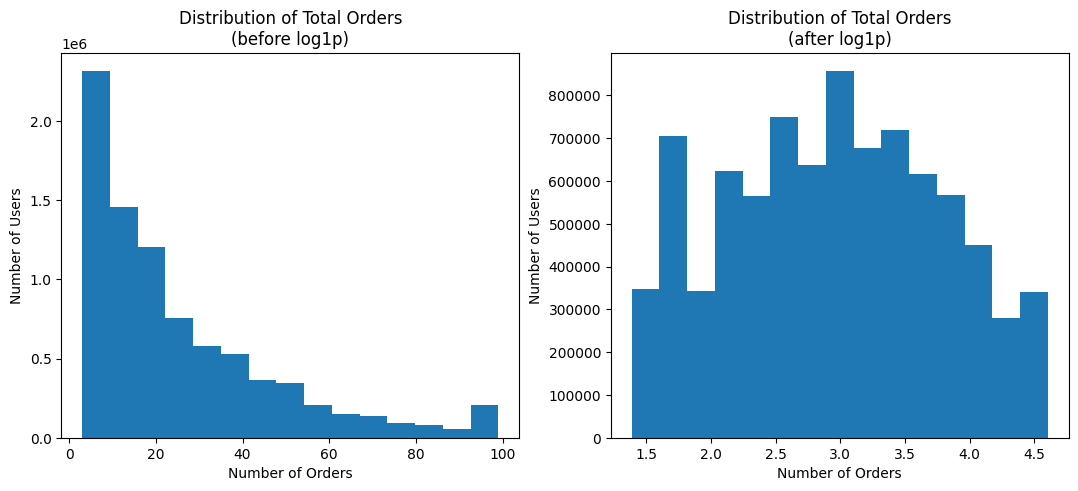

In [14]:
fig,axes=plt.subplots(1,2,figsize=(13,5))

axes[0].hist(full_train['total_orders'],bins=15)
axes[0].set_xlabel('Number of Orders')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Total Orders\n(before log1p)')

axes[1].hist(full_train['total_orders_log'],bins=15)
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Distribution of Total Orders\n(after log1p)')

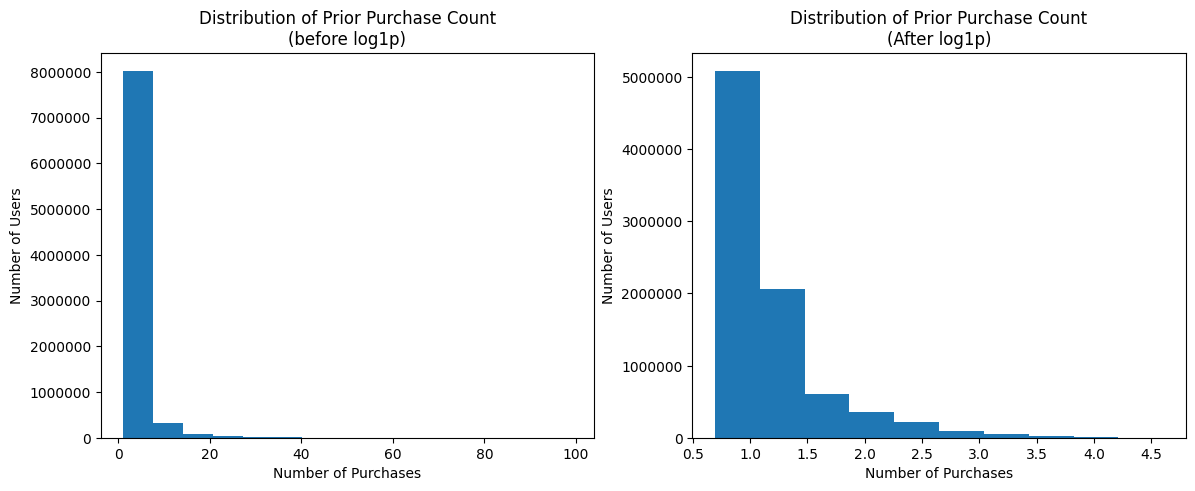

In [15]:
fig,axes=plt.subplots(1,2,figsize=(14,5))

axes[0].hist(full_train['prior_purchase_count'],bins=15)
axes[0].set_xlabel('Number of Purchases')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Prior Purchase Count\n(before log1p)')
axes[0].ticklabel_format(style='plain')



axes[1].hist(full_train['prior_purchase_count_log'])
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Distribution of Prior Purchase Count\n(After log1p)')
axes[1].ticklabel_format(style='plain')


Dropping the columns before log1p and kept the the logged ones.

In [13]:
full_train=full_train.drop(columns=col_to_log)
full_train.head()

,user_id,product_id,order_id,eval_set,order_dow,order_hour_of_day,days_since_prior_order,is_first_order,product_name,aisle_id,...,mean_days_last3,prior_purchase_count_log,product_popularity_log,total_orders_log,order_number_log,avg_basket_size_log,avg_basket_size_last3_log,total_reorders_log,avg_cart_position_log,median_cart_position_log
0,202279,33120,1050357,train,1,14,30.0,0,Organic Egg Whites,86,...,28.0,1.791759,9.873080,2.197225,2.302585,2.505526,2.662588,1.609438,1.098612,0.693147
1,202279,28985,1050357,train,1,14,30.0,0,Michigan Organic Kale,83,...,28.0,1.791759,11.119142,2.197225,2.302585,2.505526,2.662588,1.609438,1.435085,1.098612
2,202279,9327,1050357,train,1,14,30.0,0,Garlic Powder,104,...,28.0,0.693147,8.748305,2.197225,2.302585,2.505526,2.662588,0.000000,1.386294,1.386294
3,202279,45918,1050357,train,1,14,30.0,0,Coconut Butter,19,...,28.0,1.791759,6.613384,2.197225,2.302585,2.505526,2.662588,1.609438,1.757858,1.609438
4,202279,30035,1050357,train,1,14,30.0,0,Natural Sweetener,17,...,28.0,1.386294,6.345636,2.197225,2.302585,2.505526,2.662588,1.098612,1.734601,1.791759


In [14]:
vif_cols = ['reorder_ratio','mean_days_between_orders','last_order_recency','mean_days_last3',
    'total_orders_log','product_reorder_rate','avg_pos_in_cart','product_popularity_log','avg_basket_size_log',
    'avg_basket_size_last3_log','order_number_log','days_since_prior_order','prior_purchase_count_log','total_reorders_log','avg_cart_position_log',
    "median_cart_position_log"]


X_vif = full_train[vif_cols].copy()
X_vif = X_vif.replace([np.inf, -np.inf], np.nan).fillna(0)

vif_df = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    }).sort_values("VIF", ascending=False).reset_index(drop=True)

vif_df

,feature,VIF
0,order_number_log,16443.008466
1,total_orders_log,14272.591223
2,avg_cart_position_log,514.293762
3,median_cart_position_log,480.877310
4,prior_purchase_count_log,331.755366
5,avg_basket_size_log,136.360093
6,total_reorders_log,101.892938
7,avg_basket_size_last3_log,92.964304
8,avg_pos_in_cart,46.827008
9,product_popularity_log,28.529806


Dropped some of the columns that have very high vif, others will be regularized.

In [15]:
X_vif=X_vif.drop(columns=['order_number_log','median_cart_position_log','avg_basket_size_log','mean_days_between_orders',
                          'product_reorder_rate','prior_purchase_count_log'],axis=1)
X_vif = X_vif.replace([np.inf, -np.inf], np.nan).fillna(0)

vif_df = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False).reset_index(drop=True)

vif_df

,feature,VIF
0,total_orders_log,34.041879
1,avg_basket_size_last3_log,30.114380
2,avg_pos_in_cart,29.965617
3,reorder_ratio,21.409202
4,avg_cart_position_log,14.879807
5,product_popularity_log,14.195322
6,mean_days_last3,10.982462
7,last_order_recency,6.954138
8,days_since_prior_order,3.981020
9,total_reorders_log,1.806289


In [18]:
full_train.head()

,user_id,product_id,order_id,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department,reordered,reorder_ratio,...,days_since_last_purchase,avg_reorder_prob,first_order_number,last_order_number,mean_days_last3,product_popularity_log,total_orders_log,avg_basket_size_last3_log,total_reorders_log,avg_cart_position_log
0,202279,33120,1050357,1,14,30.0,86,dairy eggs,1,0.477778,...,30.0,0.800000,1,8,28.0,9.873080,2.197225,2.662588,1.609438,1.098612
1,202279,28985,1050357,1,14,30.0,83,produce,0,0.477778,...,30.0,0.800000,1,6,28.0,11.119142,2.197225,2.662588,1.609438,1.435085
2,202279,9327,1050357,1,14,30.0,104,pantry,0,0.477778,...,8.0,0.000000,3,3,28.0,8.748305,2.197225,2.662588,0.000000,1.386294
3,202279,45918,1050357,1,14,30.0,19,pantry,0,0.477778,...,24.0,0.800000,2,7,28.0,6.613384,2.197225,2.662588,1.609438,1.757858
4,202279,30035,1050357,1,14,30.0,17,pantry,0,0.477778,...,24.0,0.666667,3,7,28.0,6.345636,2.197225,2.662588,1.098612,1.734601


## Dropping Columns That We Won't Be Used Further (Redundant/leakage/meaningless).

In [17]:
col_to_drop=['order_number_log','median_cart_position_log','avg_basket_size_log','mean_days_between_orders',
            'product_reorder_rate','prior_purchase_count_log','eval_set','is_first_order','department_id','aisle','product_name',
            'is_morning','is_afternoon','is_evening']
full_train=full_train.drop(columns=col_to_drop,axis=1)
full_train.head()

,user_id,product_id,order_id,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department,reordered,reorder_ratio,...,days_since_last_purchase,avg_reorder_prob,first_order_number,last_order_number,mean_days_last3,product_popularity_log,total_orders_log,avg_basket_size_last3_log,total_reorders_log,avg_cart_position_log
0,202279,33120,1050357,1,14,30.0,86,dairy eggs,1,0.477778,...,30.0,0.800000,1,8,28.0,9.873080,2.197225,2.662588,1.609438,1.098612
1,202279,28985,1050357,1,14,30.0,83,produce,0,0.477778,...,30.0,0.800000,1,6,28.0,11.119142,2.197225,2.662588,1.609438,1.435085
2,202279,9327,1050357,1,14,30.0,104,pantry,0,0.477778,...,8.0,0.000000,3,3,28.0,8.748305,2.197225,2.662588,0.000000,1.386294
3,202279,45918,1050357,1,14,30.0,19,pantry,0,0.477778,...,24.0,0.800000,2,7,28.0,6.613384,2.197225,2.662588,1.609438,1.757858
4,202279,30035,1050357,1,14,30.0,17,pantry,0,0.477778,...,24.0,0.666667,3,7,28.0,6.345636,2.197225,2.662588,1.098612,1.734601


Convert int64 , float64 to int32 , float32 for saving memory.

In [19]:
for col in full_train.select_dtypes(include=['float64']).columns:
    full_train[col]=full_train[col].astype('float32')

# Convert int64 to int32
for col in full_train.select_dtypes(include=['int64']).columns:
    full_train[col]=full_train[col].astype('int32')

In [20]:
full_train.shape[0]

8474661

Building training and validation(test) df , using order_id as time (higher order_id -> later order).

since full train is 8m and 470k rows , we splitted the data 90% train and 10% val.

In [21]:
df=orders.loc[orders['eval_set']=='train',['user_id','order_id']].sort_values('order_id')
split=int(len(df)*0.9)
train_user_ids=df.iloc[:split]['user_id']
val_user_ids=df.iloc[split:]['user_id']


df_train=full_train[full_train['user_id'].isin(train_user_ids)].copy()
df_train=df_train.sort_values('order_id')
df_val=full_train[full_train['user_id'].isin(val_user_ids)].copy()
df_val=df_val.sort_values('order_id')

Order id is increasing which means (earlier -> later).

In [22]:
print(df_train['order_id'].is_monotonic_increasing)
print(df_val['order_id'].is_monotonic_increasing)

True
True


In [23]:
X_train=df_train.drop(columns=['reordered'],axis=1)
y_train=df_train['reordered']

X_val=df_val.drop(columns=['reordered'],axis=1)
y_val=df_val['reordered']

In [24]:
print('X train number of rows :',X_train.shape[0])
print('y train number of rows :',y_train.shape[0])
print('X val number of rows :',X_val.shape[0])
print('y val number of rows :',y_val.shape[0])

X train number of rows : 7629090
y train number of rows : 7629090
X val number of rows : 845571
y val number of rows : 845571


Top 10 features corrolated to the target (reordered).

Top 10 features by correlation with target:
total_reorders_log           0.272587
avg_reorder_prob             0.247731
avg_pos_in_cart              0.127763
product_popularity_log       0.115951
total_orders_log             0.108257
days_since_last_purchase     0.081428
first_order_number           0.077350
avg_basket_size_last3_log    0.049142
mean_days_last3              0.043976
days_since_prior_order       0.042831
dtype: float64


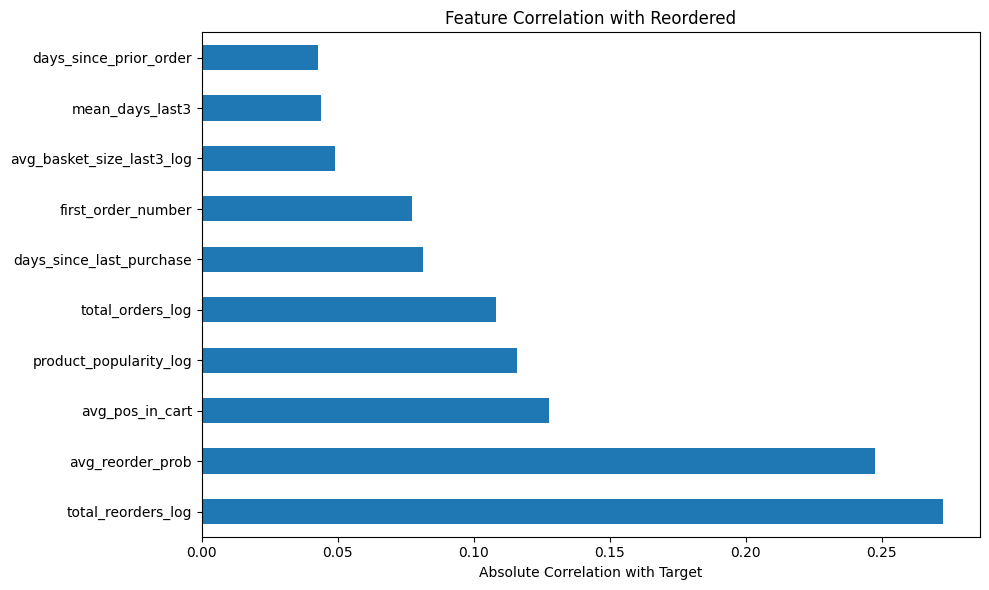

In [ ]:
correlations=X_train.corrwith(y_train,numeric_only=True).abs().sort_values(ascending=False)

print("Top 10 features by correlation with target:")
print(correlations.head(10))

plt.figure(figsize=(10, 6))
correlations.head(10).plot(kind='barh')
plt.xlabel('Absolute Correlation with Target')
plt.title('Feature Correlation with Reordered')
plt.tight_layout()
plt.show()

## Encoding Comparision

Higher unique number means higher cardinality.

In [25]:
df_train.nunique()

user_id                      118088
product_id                    49340
order_id                     118088
order_dow                         7
order_hour_of_day                24
days_since_prior_order           31
aisle_id                        134
department                       21
reordered                         2
reorder_ratio                 22768
last_order_recency               31
avg_pos_in_cart               25447
days_since_last_purchase         31
avg_reorder_prob                 99
first_order_number               99
last_order_number                99
mean_days_last3                  91
product_popularity_log         4161
total_orders_log                 97
avg_basket_size_last3_log       173
total_reorders_log               99
avg_cart_position_log         11745
dtype: int64

In [26]:
low_card=['order_dow','department','order_hour_of_day']
high_cat=['user_id', 'product_id'] 

todrop=['aisle_id','order_id']+low_card+high_cat
num_col=[c for c in X_train.columns if not c in todrop]

id_col=['user_id','product_id','order_id']

In [27]:
num_col

['days_since_prior_order',
 'reorder_ratio',
 'last_order_recency',
 'avg_pos_in_cart',
 'days_since_last_purchase',
 'avg_reorder_prob',
 'first_order_number',
 'last_order_number',
 'mean_days_last3',
 'product_popularity_log',
 'total_orders_log',
 'avg_basket_size_last3_log',
 'total_reorders_log',
 'avg_cart_position_log']

Used Logisticregression for encoding comaprision because its simple, fast and sensitive to how categories are encoded.

Firstly onehot encoder.

In [39]:
preprocess_ohe=ColumnTransformer(transformers=[('onehot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                               ('scaler',StandardScaler(),num_col)],remainder='drop')

ohe_pipeline=Pipeline(steps=[('preprocess',preprocess_ohe),
                            ('model',LogisticRegression(max_iter=3000))])
ohe_pipeline

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [40]:
ohe_pipeline.fit(X_train.drop(columns=['user_id','product_id','order_id'],errors='ignore'),y_train)
y_pred=ohe_pipeline.predict_proba(X_val)[:, 1]
roc_auc_ohe=roc_auc_score(y_val, y_pred)
avg_pr_ohe=average_precision_score(y_val, y_pred)

roc_auc_ohe, avg_pr_ohe

(0.8087511587356322, 0.37547434003650415)

used leaveoneout instead of targetencode because Leave-one-out (LOO) encoding fixes leak by computing the category mean excluding the current row’s label, so each row doesn’t see itself.

In [28]:
te_safe=ce.LeaveOneOutEncoder(cols=['product_id','user_id'],sigma=0.05)

preprocess_target=ColumnTransformer(transformers=[
    ('te', te_safe, high_cat),
    ('onehot',OneHotEncoder(handle_unknown='ignore'), low_card),
    ('num',StandardScaler(), num_col)
], remainder='drop')

target_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_target),
    ('model', LogisticRegression(max_iter=300, class_weight='balanced'))
])

used TimeSeriesSplit since it train on past and validate on future.

In [33]:
cv=TimeSeriesSplit(n_splits=3)
scores=cross_validate(
    target_pipeline,
    X_train, y_train,
    cv=cv,
    scoring={"roc_auc": "roc_auc", "avg_pr": "average_precision"},
    n_jobs=-1
)
float(scores["test_roc_auc"].mean()),float(scores["test_avg_pr"].mean())

(0.8047445899744546, 0.35286084551382085)

In [34]:
target_pipeline.fit(X_train, y_train)
proba=target_pipeline.predict_proba(X_val)[:, 1]
roc_auc_target=roc_auc_score(y_val, proba)
avg_pr_target=average_precision_score(y_val, proba)
(roc_auc_target,avg_pr_target)

(0.806055407739408, 0.3576588002533561)

Frequency encoder.

In [35]:
preprocess_frequency=ColumnTransformer(transformers=[('freq',ce.CountEncoder(cols=high_cat,normalize=True),high_cat),
                                                     ('onehot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                                     ('num',StandardScaler(),num_col)],remainder='drop')
frequency_pipeline=Pipeline(steps=[('preprocess',preprocess_frequency),
                                  ('model',LogisticRegression(n_jobs=-1,max_iter=5000,class_weight='balanced'))])
frequency_pipeline

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('freq', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
frequency_pipeline.fit(X_train.drop(columns=['order_id'],errors='ignore'),y_train)
proba=frequency_pipeline.predict_proba(X_val)[:,1]
roc_auc_freq=roc_auc_score(y_val,proba)
avg_pr_freq=average_precision_score(y_val,proba)

(roc_auc_freq,avg_pr_freq)

(0.8091618145638666, 0.3731235728191093)

All encoders achieved similiar scores, OneHot and Frequency is likely the same results but target was the lowest between them. chose onehot as the main encoder.

In [41]:
results=pd.DataFrame({'roc_auc':[roc_auc_ohe,roc_auc_target,roc_auc_freq],
                      'avg_pr_score':[avg_pr_ohe,avg_pr_target,avg_pr_freq]},index=['OneHotEnc','TargetEnc','FrequencyEnc'])
results

,roc_auc,avg_pr_score
OneHotEnc,0.808751,0.375474
TargetEnc,0.806055,0.357659
FrequencyEnc,0.809162,0.373124


## Imbalanced data handling

we have a very highly imbalanced data (90% not reordered and 10% reordered). we will comapre different approaches of imbalanced handling.

In [42]:
print(f"reordered rate in train: {df_train['reordered'].mean():.2f}\nreordered rate in validation: {df_val['reordered'].mean():.2f}\n")
print(f"not reordered rate in train: {1-df_train['reordered'].mean():.2f}\nnot reordered rate in validation: {1-df_val['reordered'].mean():.2f}")

reordered rate in train: 0.10
reordered rate in validation: 0.10

not reordered rate in train: 0.90
not reordered rate in validation: 0.90


## Basline Model without any adjustment.

shows the model is conservative (predicting 1 rarely -> high precision , low recall), accuracy is very high because the data is imbalanced so if model predict 0 all time it will get 90% score.

In [43]:
ct=ColumnTransformer(transformers=[('onehot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                   ('scaler',StandardScaler(),num_col)],remainder='drop')
base_pipline=Pipeline(steps=[('preprocess',ct),
                             ('model',LogisticRegression(n_jobs=-1))])
base_pipline.fit(X_train.drop(columns=['user_id','product_id','order_id'], errors='ignore'),y_train)
y_pred=base_pipline.predict(X_val)
print(classification_report(y_val, y_pred,digits=2))


              precision    recall  f1-score   support

           0       0.91      0.99      0.95    762527
           1       0.63      0.13      0.21     83044

    accuracy                           0.91    845571
   macro avg       0.77      0.56      0.58    845571
weighted avg       0.88      0.91      0.88    845571



## Weighted Model

weighted model showed improvement in recall and worsening the precision. but overall its better than base since f1 increased from 0.21 to 0.35.

In [44]:
weight_pipline=Pipeline(steps=[('preprocess',ct),
                             ('model',LogisticRegression(class_weight='balanced',max_iter=3000))])
weight_pipline.fit(X_train,y_train)
y_pred_weight=weight_pipline.predict(X_val)
print(classification_report(y_val,y_pred_weight))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83    762527
           1       0.23      0.73      0.35     83044

    accuracy                           0.73    845571
   macro avg       0.60      0.73      0.59    845571
weighted avg       0.89      0.73      0.79    845571



## Smote + Baseline Model

Smote will be very slow on the full training data so we use sample to train and evalute.

we used smotenc instead of smote because smote works only for continous numeric and smotenc works for mixed.

In [ ]:
drop_ids =['user_id','product_id','order_id','department']
X_sample = X_train.sort_values("order_id").head(600000)
y_sample = y_train.loc[X_sample.index]

X_sample=X_sample.drop(columns=['user_id','product_id','order_id','department'], errors='ignore')
X_val2=X_val.drop(columns=['user_id','product_id','order_id','department'], errors='ignore')

low_card_smote = ['order_dow','order_hour_of_day']

all_cols = list(X_sample.columns)
pass_cols = [c for c in all_cols if c not in num_col]

cat_idx=[len(num_col)+pass_cols.index(c)for c in low_card_smote]

Smote shows the best f1 score.

In [46]:
ct_smote=ColumnTransformer(transformers=[('scaler',StandardScaler(),num_col)],remainder='passthrough')
smote_pipline=ImbPipeline(steps=[('preprocess',ct_smote),
                                 ('smote',SMOTENC(categorical_features=cat_idx,sampling_strategy=0.30,random_state=42,k_neighbors=3)),
                                 ('model',LogisticRegression(n_jobs=-1))])

                          
smote_pipline.fit(X_sample,y_sample)                                                                    
y_pred_smote=smote_pipline.predict(X_val2)
print(classification_report(y_val, y_pred_smote))                                                                              

              precision    recall  f1-score   support

           0       0.93      0.94      0.93    762527
           1       0.40      0.39      0.40     83044

    accuracy                           0.88    845571
   macro avg       0.67      0.66      0.67    845571
weighted avg       0.88      0.88      0.88    845571



In [57]:
print("Smote Average Precision: ",average_precision_score(y_val,smote_pipline.predict_proba(X_val2)[:,1]))
print('Smote Roc Auc: ',roc_auc_score(y_val,smote_pipline.predict_proba(X_val2)[:,1]))

Smote Average Precision:  0.3689262814304781
Smote Roc Auc:  0.8062754023025244


## UnderSampling

undersampled the data from 90% / 10% to 75% / 25%.

In [73]:
pos=df_train[df_train['reordered'] == 1]
neg=df_train[df_train['reordered'] == 0]

ratio=3
neg_sample=neg.sample(n=min(len(neg),ratio*len(pos)),random_state=42)
df_train_us=pd.concat([pos,neg_sample]).sample(frac=1,random_state=42)
df_train_us=df_train_us.sort_values('order_id')
X_train_us=df_train_us.drop(columns=['reordered'])
y_train_us=df_train_us['reordered']

In [74]:
print("y_train mean:", y_train.mean())
print("y_train_us mean:", y_train_us.mean())


y_train mean: 0.09775477809280006
y_train_us mean: 0.25


the baseline logistic shows an improvment with the undersampled data.

In [75]:
base_pipline=Pipeline(steps=[('preprocess',ct),
                             ('model',LogisticRegression(n_jobs=-1))])
base_pipline.fit(X_train_us.drop(columns=['user_id','order_id','product_id']),y_train_us)
y_pred=base_pipline.predict(X_val)
print(classification_report(y_val, y_pred,digits=2))


              precision    recall  f1-score   support

           0       0.94      0.93      0.93    762527
           1       0.39      0.41      0.40     83044

    accuracy                           0.88    845571
   macro avg       0.66      0.67      0.67    845571
weighted avg       0.88      0.88      0.88    845571



precision-recall tradeoff 

lower thresholds -> model predicts fewer 1 -> higher precision -> lower recall

higher thresholds -> model predicts more 1 -> lower precision -> higher recall

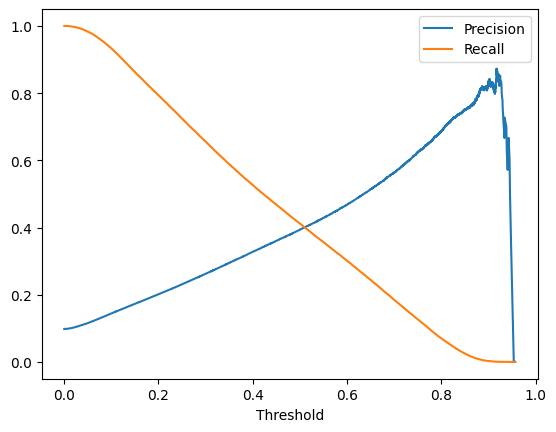

In [76]:
y_pred=base_pipline.predict_proba(X_val)[:,1]
precisions,recalls,thresholds=precision_recall_curve(y_val,y_pred)

plt.plot(thresholds,precisions[:-1],label='Precision')
plt.plot(thresholds,recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [67]:
print('roc auc score: ',roc_auc_score(y_val,base_pipline.predict_proba(X_val)[:,1]))
print('Ap: ',average_precision_score(y_val,y_pred))

roc auc score:  0.80918483227109
Ap:  0.37298020113810315


## Classification Models

### Logistic Regression

base logistic (l2)

In [38]:
ct=ColumnTransformer(transformers=[('onehot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                   ('scaler',StandardScaler(),num_col)],remainder='drop')
l2_log=Pipeline(steps=[('preprocess',ct),
                       ('model',LogisticRegression(max_iter=3000,n_jobs=-1))])
l2_log.fit(X_train,y_train)
l2_y_pred=l2_log.predict(X_val)
proba=l2_log.predict_proba(X_val)[:,1]

results at threshold 0.5 are weak showing that model is strugling. but we can adjust the threshold for better results.

In [45]:
print("classification report for baseline logistic at threshold 0.5 :\n",'\n',classification_report(y_val,l2_y_pred))

classification report for baseline logistic at threshold 0.5 :
 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95    762527
           1       0.63      0.13      0.21     83044

    accuracy                           0.91    845571
   macro avg       0.77      0.56      0.58    845571
weighted avg       0.88      0.91      0.88    845571



the precsion-recall tradeoff plot shows that threshold ~ 0.3 has the best f1 result.

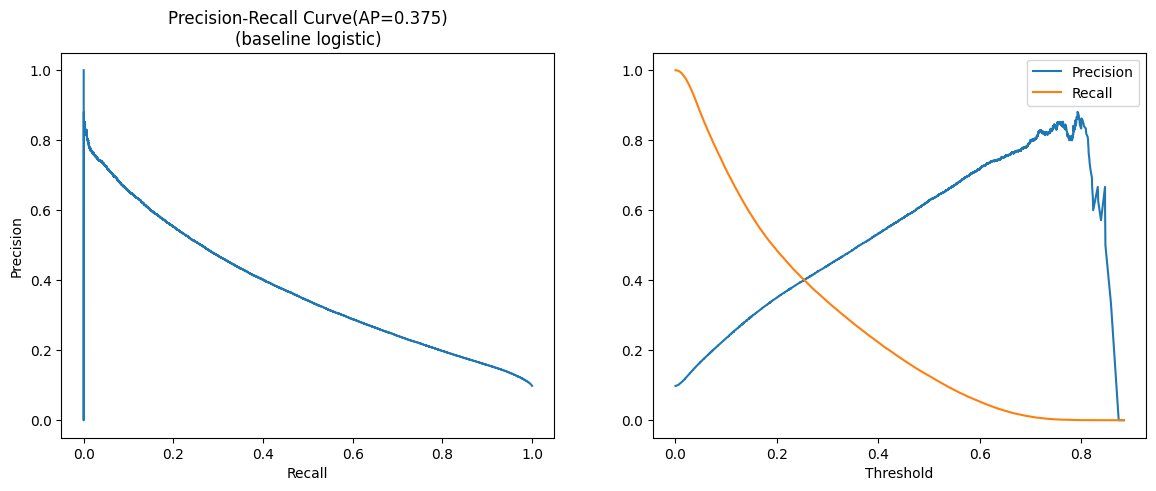

In [51]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
prec,rec,thresholds=precision_recall_curve(y_val,proba)
ap=average_precision_score(y_val,proba)
axes[0].plot(rec,prec)
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].set_title(f"Precision-Recall Curve(AP={ap:.3f})\n(baseline logistic)")

axes[1].plot(thresholds,prec[:-1],label='Precision')
axes[1].plot(thresholds,rec[:-1], label='Recall')
axes[1].set_xlabel('Threshold')
axes[1].legend()


Text(0.5, 1.0, 'Confusion Matrix (normalized)')

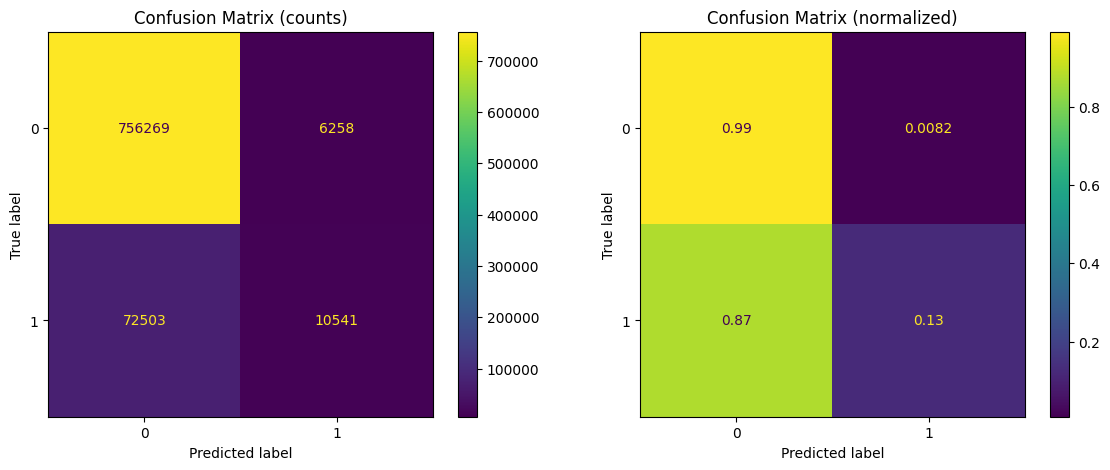

In [46]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
ConfusionMatrixDisplay.from_predictions(y_val,l2_y_pred,normalize=None,ax=axes[0])
axes[0].set_title("Confusion Matrix (counts)")

ConfusionMatrixDisplay.from_predictions(y_val,l2_y_pred,normalize="true",ax=axes[1])
axes[1].set_title("Confusion Matrix (normalized)")

l1 logistic shows same results as the base one.

In [ ]:
l1_log=Pipeline(steps=[('preprocess',ct),
                       ('model',LogisticRegression(penalty='l1',solver='saga',n_jobs=-1,max_iter=2000))])
l1_log.fit(X_train,y_train)
l1_y_pred=l1_log.predict(X_val)
proba=l1_log.predict_proba(X_val)[:,1]

In [119]:
print("classification report for L1 logistic:\n",'\n',classification_report(y_val,l1_y_pred))

classification report for L1 logistic:
 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95    762527
           1       0.64      0.09      0.16     83044

    accuracy                           0.91    845571
   macro avg       0.77      0.54      0.55    845571
weighted avg       0.88      0.91      0.87    845571



Logistic shows better results with weight.

In [47]:
l2_weight_log=Pipeline(steps=[('preprocess',ct),
                       ('model',LogisticRegression(max_iter=3000,n_jobs=-1,class_weight='balanced'))])
l2_weight_log.fit(X_train,y_train)
l2_weight_y_pred=l2_weight_log.predict(X_val)
proba=l2_weight_log.predict_proba(X_val)[:,1]

In [48]:
print("classification report for L2 Balanced logistic:\n",'\n',classification_report(y_val,l2_weight_y_pred))

classification report for L2 Balanced logistic:
 
               precision    recall  f1-score   support

           0       0.96      0.73      0.83    762527
           1       0.23      0.73      0.35     83044

    accuracy                           0.73    845571
   macro avg       0.60      0.73      0.59    845571
weighted avg       0.89      0.73      0.79    845571



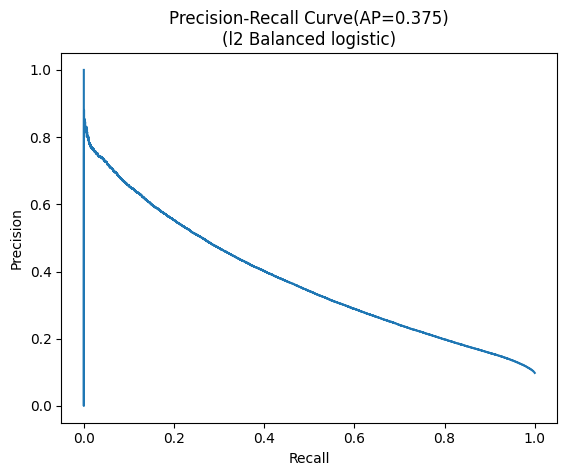

In [53]:
prec,rec,_=precision_recall_curve(y_val,proba)
ap=average_precision_score(y_val,proba)
plt.plot(rec,prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve(AP={ap:.3f})\n(l2 Balanced logistic)")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix (normalized)')

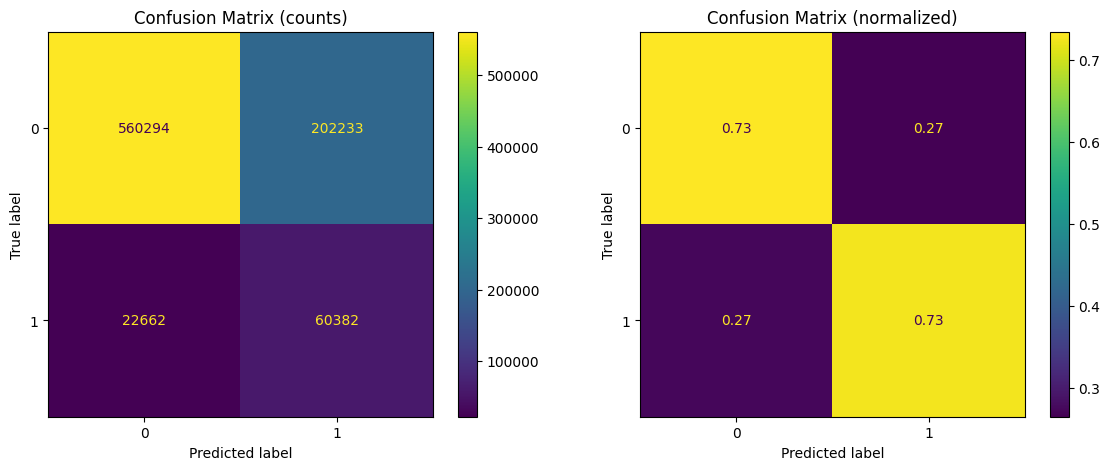

In [54]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
ConfusionMatrixDisplay.from_predictions(y_val, l2_weight_y_pred, normalize=None,ax=axes[0],values_format='d')
axes[0].set_title("Confusion Matrix (counts)")

ConfusionMatrixDisplay.from_predictions(y_val, l2_weight_y_pred, normalize="true",ax=axes[1],values_format='.2f')
axes[1].set_title("Confusion Matrix (normalized)")

We chose 

In [ ]:
X2_train=df_train[['avg_reorder_prob','days_since_last_purchase']].values
y2_train=df_train["reordered"].values

X2_val=df_val[["avg_reorder_prob","days_since_last_purchase"]].values
y2_val=df_val["reordered"].values
l2_bal_2d=make_pipeline(StandardScaler(),
                        LogisticRegression())
l2_bal_2d.fit(X2_train,y2_train)

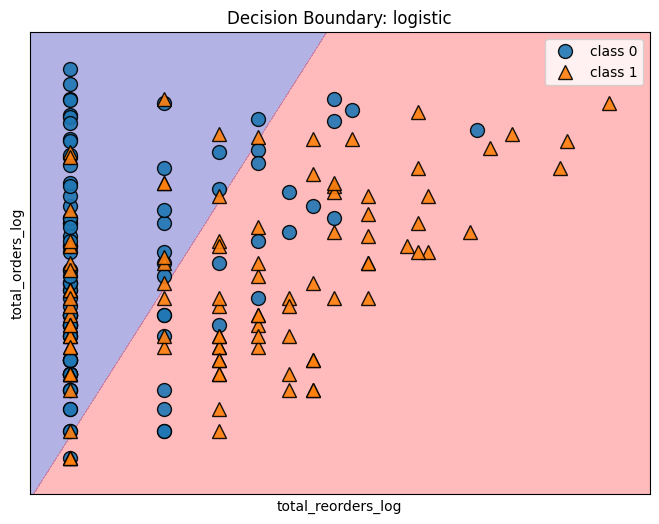

In [50]:
feat1="total_reorders_log"
feat2="total_orders_log"

dfp=df_train[[feat1, feat2, "reordered"]]
pos=dfp[dfp["reordered"] == 1].sample(n=100, random_state=42)
neg=dfp[dfp["reordered"] == 0].sample(n=100, random_state=42)
dfp=pd.concat([pos, neg]).sample(frac=1, random_state=42)

X=dfp[[feat1, feat2]].to_numpy()
y=dfp["reordered"].to_numpy()

l2_bal_2d=make_pipeline(StandardScaler(),
                        LogisticRegression())
l2_bal_2d.fit(X,y)
plt.figure(figsize=(8, 6))
mglearn.plots.plot_2d_separator(l2_bal_2d,X,fill=True,alpha=0.3,eps=0.3)
mglearn.discrete_scatter(X[:, 0], X[:, 1],y,alpha=0.9,s=10)

plt.xlabel("total_reorders_log")
plt.ylabel("total_orders_log")
plt.title("Decision Boundary: logistic")
plt.legend(["class 0", "class 1"], loc="best")
plt.show()

We will use 800k row for the tunning to make the process faster , then fitting the tunned model on the full data.

In [102]:
X_tune=X_train.sort_values('order_id').head(800_000)
y_tune=y_train.loc[X_tune.index]
X_tune=X_tune.drop(columns=['order_id','user_id'])

In [103]:
grid_pip=Pipeline(steps=[('preprocess',ct),
                         ('logistic',LogisticRegression(n_jobs=-1,random_state=42,max_iter=3000))])
param_grid=[{
    'logistic__C':[0.001,0.01,0.1,0.3,1],
    'logistic__class_weight':[None,'balanced',{0:1,1:3}],
    'logistic__penalty':['l1','l2'],
    'logistic__solver':['saga']                                                                                                        
}]
                          
tscv=TimeSeriesSplit(n_splits=3)
grid_search=HalvingGridSearchCV(grid_pip,param_grid,cv=tscv,scoring='average_precision',n_jobs=-1)
grid_search.fit(X_tune,y_tune)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'logistic__C': [0.001, 0.01, ...], 'logistic__class_weight': [None, 'balanced', ...], 'logistic__penalty': ['l1', 'l2'], 'logistic__solver': ['saga']}]"
,factor,3
,resource,'n_samples'
,max_resources,'auto'
,min_resources,'exhaust'
,aggressive_elimination,False
,cv,TimeSeriesSpl...est_size=None)
,scoring,'average_precision'
,refit,True
,error_score,nan


In [105]:
best_model=grid_search.best_estimator_                   
best_model.fit(X_train,y_train)                                                                                                 

,steps,"[('preprocess', ...), ('logistic', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [106]:
best_lr=grid_search.best_estimator_.named_steps["logistic"]
best_lr.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 3000,
 'multi_class': 'deprecated',
 'n_jobs': -1,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [132]:
y_pred=best_model.predict(X_val)
proba=best_model.predict_proba(X_val)[:, 1]

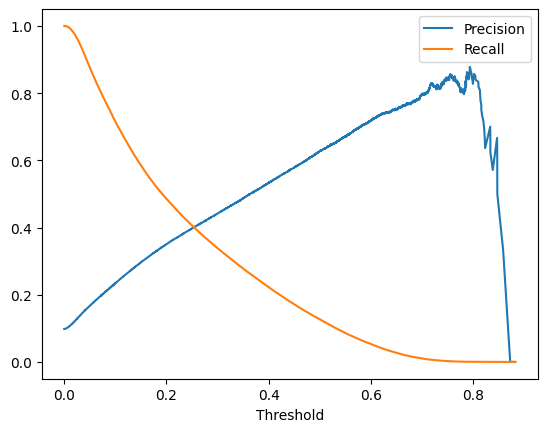

In [133]:
precisions,recalls,thresholds=precision_recall_curve(y_val, proba)

plt.plot(thresholds,precisions[:-1],label='Precision')
plt.plot(thresholds,recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Baseline AP=0.098

Model Ap=0.375

That means Model is ranking reorders ≈3.7X than random

In [109]:
ap=average_precision_score(y_val,proba)
print("Positive rate(baseline AP):",y_val.mean())
print('Model Ap rate:',ap)

Positive rate(baseline AP): 0.09821055830911893
Model Ap rate: 0.3754136175802919


#### We chose the threshold that f1 is highest at , because f1 shows the balance between recall and precision.

#### if the goal is avoiding missing reorder we choose threshold that has highest recall (threshold=0.1). 

#### if the goal is making fewer wrong prediction then we choose threshold that has highest precision (threshold=0.8).

In [121]:
y_pred=(proba>=0.2).astype(int)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92    762527
           1       0.35      0.49      0.41     83044

    accuracy                           0.86    845571
   macro avg       0.65      0.69      0.66    845571
weighted avg       0.88      0.86      0.87    845571



again, Accuracy isn't a metric that we can rely on as our data is heavly imbalanced 90/10 , so a model that predicts 0 all time will get ~90% accuracy

In [116]:
print("Accuracy On Training:",best_model.score(X_train,y_train))
print("Accuracy On Testing:",best_model.score(X_val,y_val))

Accuracy On Training: 0.9069000365705477
Accuracy On Testing: 0.9068534753438801


Text(0.5, 1.0, 'Confusion Matrix (normalized)')

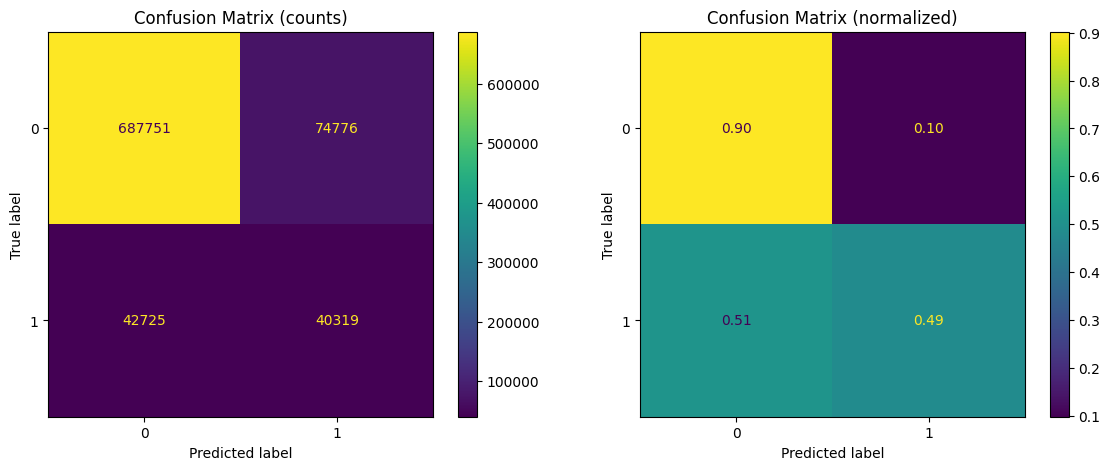

In [122]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
ConfusionMatrixDisplay.from_predictions(y_val,y_pred,normalize=None,ax=axes[0],values_format='d')
axes[0].set_title("Confusion Matrix (counts)")

ConfusionMatrixDisplay.from_predictions(y_val,y_pred,normalize="true",ax=axes[1],values_format='.2f')
axes[1].set_title("Confusion Matrix (normalized)")

the straight decision boundary slightly shifts/rotates because of the regularization constraints.

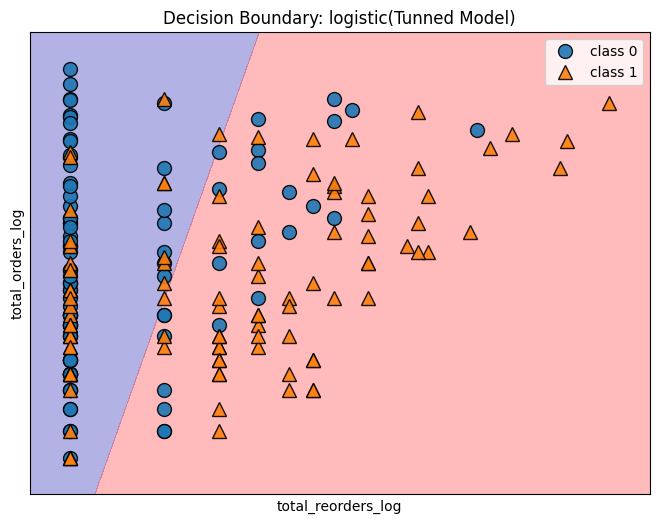

In [53]:
feat1="total_reorders_log"
feat2="total_orders_log"

dfp=df_train[[feat1, feat2, "reordered"]]
pos=dfp[dfp["reordered"] == 1].sample(n=100, random_state=42)
neg=dfp[dfp["reordered"] == 0].sample(n=100, random_state=42)
dfp=pd.concat([pos, neg]).sample(frac=1, random_state=42)

X=dfp[[feat1, feat2]].to_numpy()
y=dfp["reordered"].to_numpy()

pip_2d=make_pipeline(StandardScaler(),
                   LogisticRegression(C=0.1,class_weight=None,solver='saga',
                                      penalty='l1',n_jobs=-1,random_state=42,max_iter=3000))
pip_2d.fit(X,y)
plt.figure(figsize=(8, 6))
mglearn.plots.plot_2d_separator(pip_2d,X,fill=True,alpha=0.3,eps=0.3)
mglearn.discrete_scatter(X[:, 0], X[:, 1],y,alpha=0.9,s=10)

plt.xlabel("total_reorders_log")
plt.ylabel("total_orders_log")
plt.title("Decision Boundary: logistic(Tunned Model)")
plt.legend(["class 0", "class 1"], loc="best")
plt.show()

Uncalibrated model is already showing good curve, it predicts probabilities higher than the true ones.

Calibrated model predicted probabilities are better and close to the true ones.

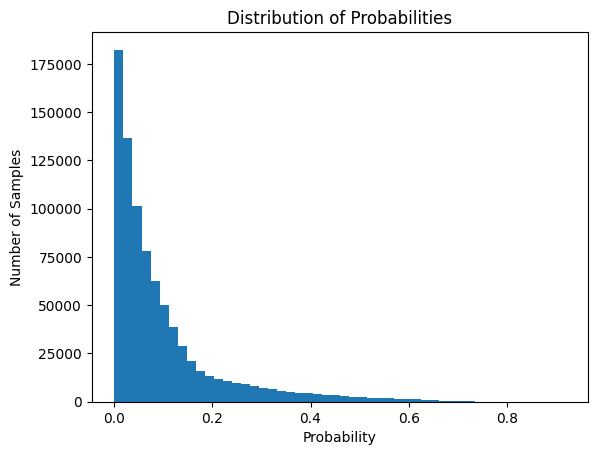

In [70]:
import matplotlib.pyplot as plt

plt.hist(proba, bins=50)
plt.title('Distribution of Probabilities')
plt.xlabel('Probability')
plt.ylabel('Number of Samples')
plt.show()

uncalibratd model probabilities are some reliable—at higher predicted probabilities the curve drifts away from the diagonal, meaning the model is miscalibrated/overconfident in that region.


In [ ]:
fig,axes=plt.subplots(1,2,figsize=(14,5))

CalibrationDisplay.from_estimator(best_model, X_val, y_val, n_bins=10,ax=axes[0])
axes[0].set_title("Uncalibrated Model")

CalibrationDisplay.from_estimator(calibrated, X_val, y_val, n_bins=10,ax=axes[1])
axes[1].set_title('calibrated Model (sigmoid)')

In [117]:
roc_auc_score(y_val,proba)

0.8088016318378598

##### Performance Converged Across the models because they are learning same signals, different approaches (SMOTE,WEIGHTED,UNDERSAMPLE) result in change the precsion/recall at a chosen threshold, but the overall ranking (ROC-AUC, AP) stayed smiliar , This suggests a feature ceiling. At the threshold >= 0.9 the model predicts very few positives because none of the samples receive probability over 0.9, and therefore, the recall and precision collapsed. 

# KNN

KNN is computationally costly mainly at prediction time. so we only used samples to train and validate it.

In [21]:
pos = df_train[df_train['reordered'] == 1]
neg = df_train[df_train['reordered'] == 0]

ratio=3
max_train=200000

pos_keep = min(len(pos), max_train // (1 + ratio))
pos_s = pos.sample(n=pos_keep, random_state=42)

neg_keep = min(len(neg), ratio * pos_keep)
neg_s = neg.sample(n=neg_keep, random_state=42)

df_train_us = pd.concat([pos_s, neg_s]).sort_values('order_id').reset_index(drop=True)

X_train_us = df_train_us.drop(columns=['reordered'])
y_train_us = df_train_us['reordered']

val_n=60000
idx = X_val.sample(n=min(val_n, len(X_val)), random_state=42).index
X_val_us = X_val.loc[idx].copy()
y_val_us = y_val.loc[idx].copy()

order = X_val_us['order_id'].sort_values().index
X_val_us = X_val_us.loc[order]
y_val_us = y_val_us.loc[order]                                                                                                                                                                                                                                 

## Base KNN

Base KNN trained on 200k and validate on 60k.

In [31]:
ct=ColumnTransformer(transformers=[('one hot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                   ('scaler',StandardScaler(),num_col)],remainder='drop')

knn_pipe = Pipeline([("preprocess", ct),                                             
                     ("knn", KNeighborsClassifier(n_neighbors=5,algorithm='brute',n_jobs=-1))])
                                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                                                                            
knn_pipe.fit(X_train_us.drop(id_col,axis=1), y_train_us)                                         
proba=knn_pipe.predict_proba(X_val_us)[:, 1]

In [34]:
y_pred=proba>=0.5
print(classification_report(y_val_us,y_pred))                                                                                     

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     54024
           1       0.28      0.40      0.33      5976

    accuracy                           0.84     60000
   macro avg       0.61      0.64      0.62     60000
weighted avg       0.87      0.84      0.85     60000



In [35]:
print('ROC AUC : ',roc_auc_score(y_val_us,proba))
print("AP: ",average_precision_score(y_val_us,proba))

ROC AUC :  0.7254817340589962
AP:  0.23011787903820652


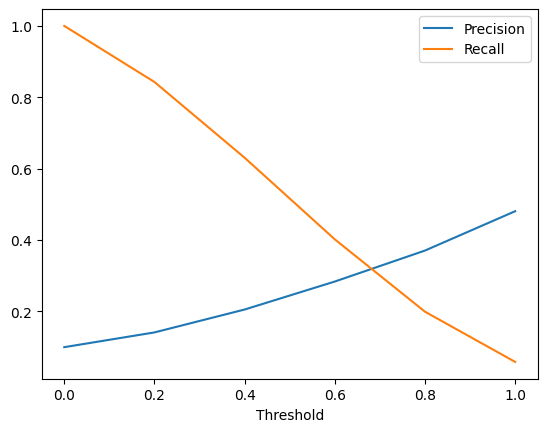

In [36]:
precisions,recalls,thresholds=precision_recall_curve(y_val_us,proba)

plt.plot(thresholds,precisions[:-1],label='Precision')
plt.plot(thresholds,recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion Matrix (normalized)')

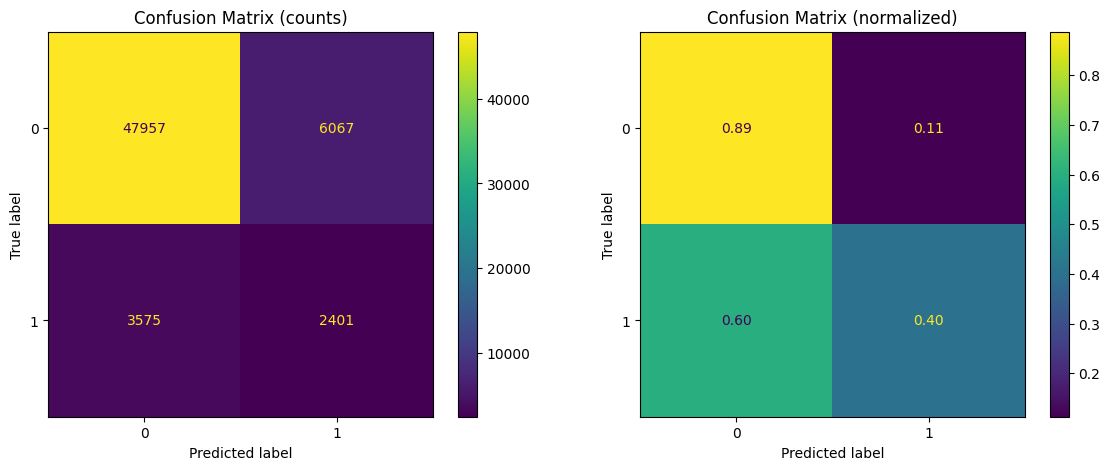

In [37]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
ConfusionMatrixDisplay.from_predictions(y_val_us,y_pred,normalize=None,ax=axes[0],values_format='d')
axes[0].set_title("Confusion Matrix (counts)")

ConfusionMatrixDisplay.from_predictions(y_val_us,y_pred,normalize="true",ax=axes[1],values_format='.2f')
axes[1].set_title("Confusion Matrix (normalized)")

## Tunned KNN

We Used 100k row to train RandomizedSearch.

In [408]:
knn_tune_pipe=Pipeline([
    ("preprocess",ct),
    ("knn", KNeighborsClassifier(algorithm='brute',n_jobs=-1))])

param_random = {
    "knn__n_neighbors":randint(10,100),
    "knn__weights":["uniform", "distance"],
    "knn__p": [1, 2],
}                                                                           
                                                                                                                                                                                                                                          
tcvs=TimeSeriesSplit(n_splits=3)
randomsearch=RandomizedSearchCV(knn_tune_pipe,param_distributions=param_random,scoring='average_precision',n_jobs=1,cv=tcvs,random_state=42)
randomsearch.fit(X_train_us.drop(columns=['user_id','order_id','product_id'],axis=1),y_train_us)

,estimator,Pipeline(step... n_jobs=-1))])
,param_distributions,"{'knn__n_neighbors': <scipy.stats....001CE9F73BD40>, 'knn__p': [1, 2], 'knn__weights': ['uniform', 'distance']}"
,n_iter,10
,scoring,'average_precision'
,n_jobs,1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [409]:
print(randomsearch.best_params_)                             
best_knn=randomsearch.best_estimator_                                                                 

{'knn__n_neighbors': 62, 'knn__p': 2, 'knn__weights': 'distance'}


Trained the tunned model using 200k rows and validate using 80k rows.

In [427]:
best_knn.fit(X_train_us.drop(columns=['user_id','order_id','product_id'],axis=1) , y_train_us)                                                                                                                                                                                                                                                                                                                                                                                           
proba_Knn=best_knn.predict_proba(X_val_us.drop(columns=['user_id','order_id','product_id'],axis=1))[:,1]

We chose The threshold that f1 is highest at.

In [432]:
y_pred=proba_Knn>=0.4
print(classification_report(y_val_us,y_pred))                                                                      

              precision    recall  f1-score   support

           0       0.94      0.87      0.91     90006
           1       0.31      0.52      0.39      9994

    accuracy                           0.84    100000
   macro avg       0.63      0.70      0.65    100000
weighted avg       0.88      0.84      0.86    100000



In [429]:
print("AP: ",average_precision_score(y_val_us,proba_Knn))
print('ROC AUC: ',roc_auc_score(y_val_us,proba_Knn))                                                                                                                                                          

AP:  0.3531197076459327
ROC AUC:  0.794763563468837


Heatmap of RandomizedSearchCV shows that k=62 and k=92 are the highest AP score.

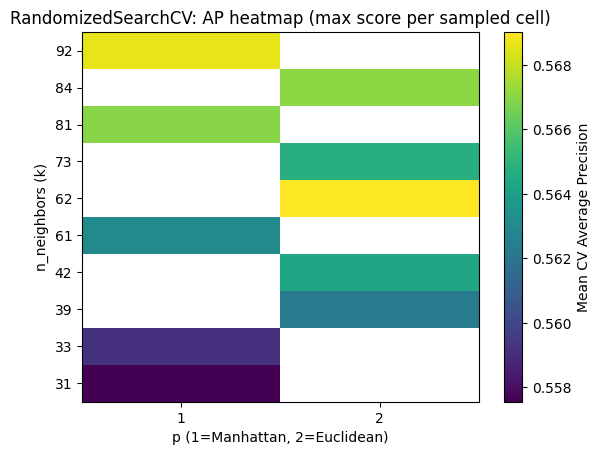

In [ ]:
res=pd.DataFrame(randomsearch.cv_results_)
heat=res.pivot_table(index="param_knn__n_neighbors",columns="param_knn__p",values="mean_test_score",aggfunc="max").sort_index()

plt.figure()
plt.imshow(heat.values, aspect="auto", origin="lower")
plt.xticks(range(len(heat.columns)), heat.columns)
plt.yticks(range(len(heat.index)), heat.index)
plt.xlabel("p (1=Manhattan, 2=Euclidean)")
plt.ylabel("n_neighbors (k)")
plt.title("RandomizedSearchCV: AP heatmap (max score per sampled cell)")
plt.colorbar(label="Mean CV Average Precision")
plt.show()

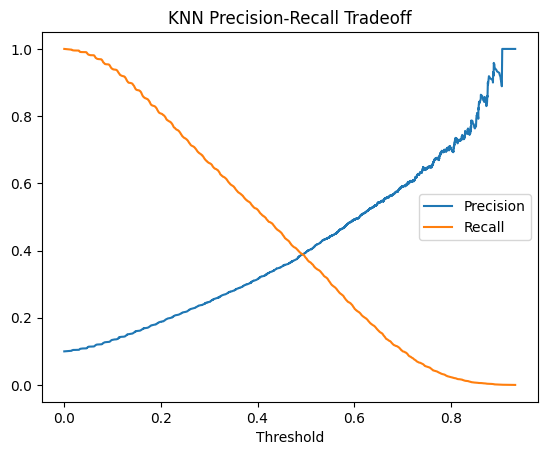

In [433]:
precisions,recalls,thresholds=precision_recall_curve(y_val_us,proba_Knn)

plt.plot(thresholds,precisions[:-1],label='Precision')
plt.plot(thresholds,recalls[:-1], label='Recall')
plt.title("KNN Precision-Recall Tradeoff")
plt.xlabel('Threshold')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion Matrix (normalized)')

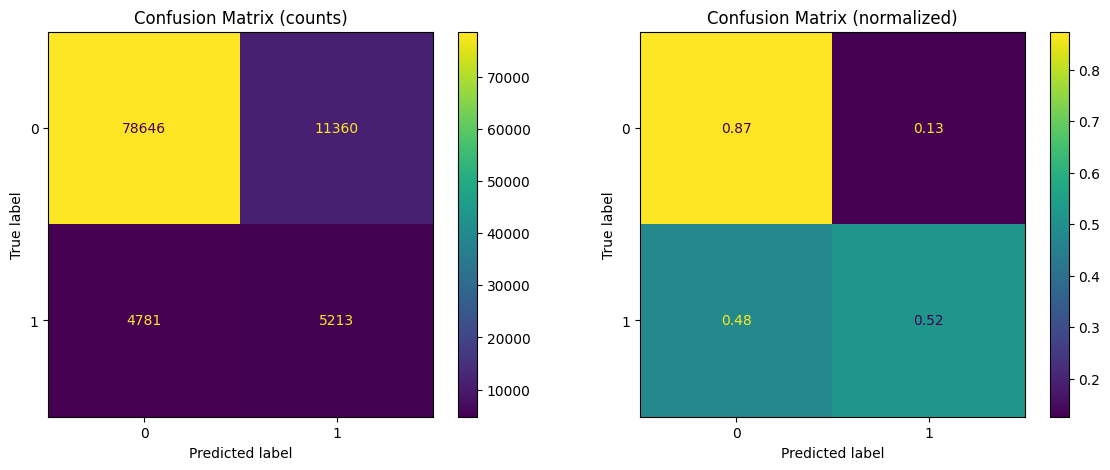

In [434]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
ConfusionMatrixDisplay.from_predictions(y_val_us,y_pred,normalize=None,ax=axes[0],values_format='d')
axes[0].set_title("Confusion Matrix (counts)")

ConfusionMatrixDisplay.from_predictions(y_val_us,y_pred,normalize="true",ax=axes[1],values_format='.2f')
axes[1].set_title("Confusion Matrix (normalized)")

In [ ]:
cal_knn = CalibratedClassifierCV(estimator=best_knn,method="sigmoid",cv=tcvs)
                                                                                                            
cal_knn.fit(X_train_us.drop(columns=['order_id','user_id','product_id'],axis=1), y_train_us)
proba_cal = cal_knn.predict_proba(X_val_us.drop(columns=['order_id','user_id','product_id']))[:, 1]

prob_true,prob_pred=calibration_curve(y_val_us,proba_cal,n_bins=20)

The calibration curve of the model indicates that model is overconfident (predicted > actual).


The calibration curve of the model after calibratied improved very slightly .

Text(0.5, 1.0, 'Calibration curve (Calibrated)')

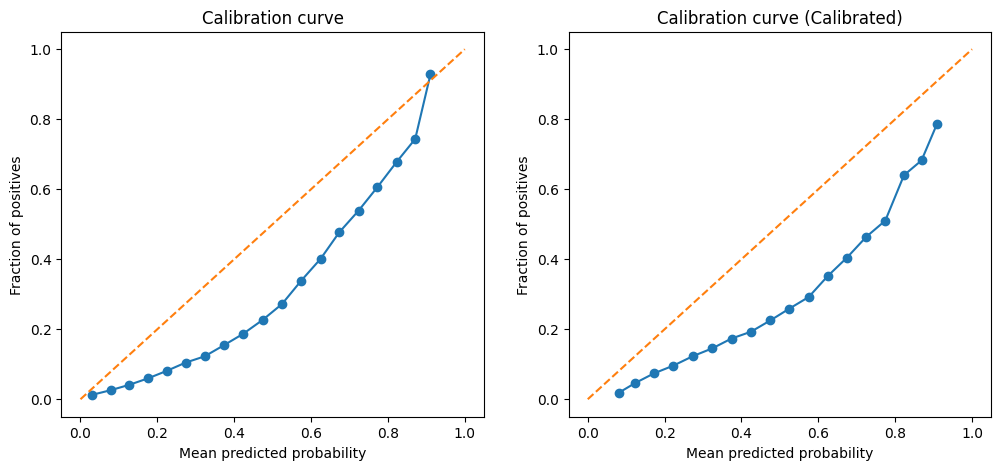

In [488]:
prob_true_cal,prob_pred_cal=calibration_curve(y_val_us,proba_cal,n_bins=20)
prob_true,prob_pred=calibration_curve(y_val_us,proba_Knn,n_bins=20)
fig,axes=plt.subplots(1,2,figsize=(12,5))

axes[0].plot(prob_pred, prob_true, marker='o')
axes[0].plot([0, 1], [0, 1], linestyle='--')
axes[0].set_xlabel("Mean predicted probability")
axes[0].set_ylabel("Fraction of positives")
axes[0].set_title("Calibration curve")


axes[1].plot(prob_pred_cal, prob_true_cal, marker='o')
axes[1].plot([0, 1], [0, 1], linestyle='--')
axes[1].set_xlabel("Mean predicted probability")
axes[1].set_ylabel("Fraction of positives")
axes[1].set_title("Calibration curve (Calibrated)")


In [480]:
print("Brier (uncal):", brier_score_loss(y_val_us, proba_Knn))        
print("Brier (cal):", brier_score_loss(y_val_us, proba_cal))                                              

Brier (uncal): 0.09704789543688401
Brier (cal): 0.09524576057728569


To Visualize knn Decision Boundry we used very small sample (n = 50) only for visualization.

with k=1 the boundry is very noisy and change around indvidual points.

with k=15 , k=38 the boundry become smoother because prediction are based more on neighbors.

This figure is only to get intuition about knn behaviour, and it doesnt represnt the decision that knn learnt from the full data.

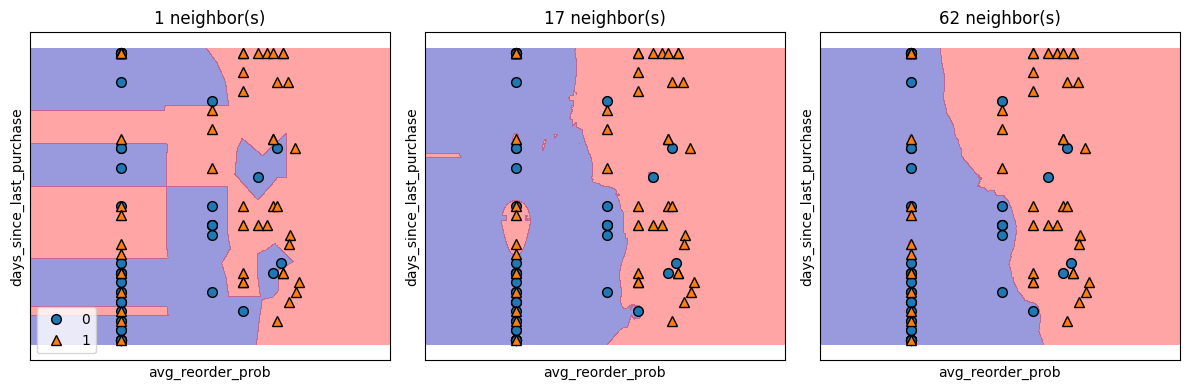

In [446]:
feat1 = "avg_reorder_prob"
feat2 = "days_since_last_purchase"

dfp = df_train[[feat1, feat2, "reordered"]]
pos = dfp[dfp["reordered"] == 1].sample(n=50, random_state=42)
neg = dfp[dfp["reordered"] == 0].sample(n=50, random_state=42)
dfp = pd.concat([pos, neg]).sample(frac=1, random_state=42)

X = dfp[[feat1, feat2]].to_numpy()
y = dfp["reordered"].to_numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for n_neighbors, ax in zip([1,17,62], axes):
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=n_neighbors, weights="distance", p=2))
    ])
    clf.fit(X, y)

    mglearn.plots.plot_2d_separator(clf, X, fill=True, eps=0.5, ax=ax, alpha=0.4)

    mglearn.discrete_scatter(X[:,0],X[:,1],y,ax=ax,s=7)

    ax.set_title(f"{n_neighbors} neighbor(s)")
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)

axes[0].legend(["0", "1"], loc=3)
plt.tight_layout()
plt.show()

## Decision Tree

# Base Decision Tree Model

Trained On 500k rows and validate on 300k

In [284]:
base_tree=Pipeline(steps=[('preprocess',ct),
                          ('tree',DecisionTreeClassifier(random_state=42))])  
                                                                                                                                                                                                                                                                                                         
base_tree.fit(X_train_us.drop(id_col,axis=1),y_train_us)                        
proba=base_tree.predict_proba(X_val_us.drop(id_col,axis=1))[:,1]                 

The results of the base tree indicates an **Overfitting**, in addition of a **weak performance** (Close to the random guessing results). .

In [292]:
proba_tr=base_tree.predict_proba(X_train_us.drop(id_col,axis=1))[:,1]

print("Train AP:", average_precision_score(y_train_us,proba_tr))
print("Val AP:", average_precision_score(y_val_us,proba))
print("Train ROC:", roc_auc_score(y_train_us,proba_tr))
print("Val ROC:", roc_auc_score(y_val_us,proba))
print("Train score: ",base_tree.score(X_train_us.drop(id_col,axis=1),y_train_us))
print("val score: ",base_tree.score(X_val_us.drop(id_col,axis=1),y_val_us))

Train AP: 1.0
Val AP: 0.151235498630565
Train ROC: 1.0
Val ROC: 0.6381016746698778
Train score:  1.0
val score:  0.7737233333333333


In [71]:
y_pred=base_tree.predict(X_val_us.drop(id_col,axis=1))
print(classification_report(y_val_us,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87    270352
           1       0.21      0.47      0.29     29648

    accuracy                           0.78    300000
   macro avg       0.57      0.64      0.58    300000
weighted avg       0.86      0.78      0.81    300000



The boundry is shaping based on the indvidual points which indicates **overfitting**.

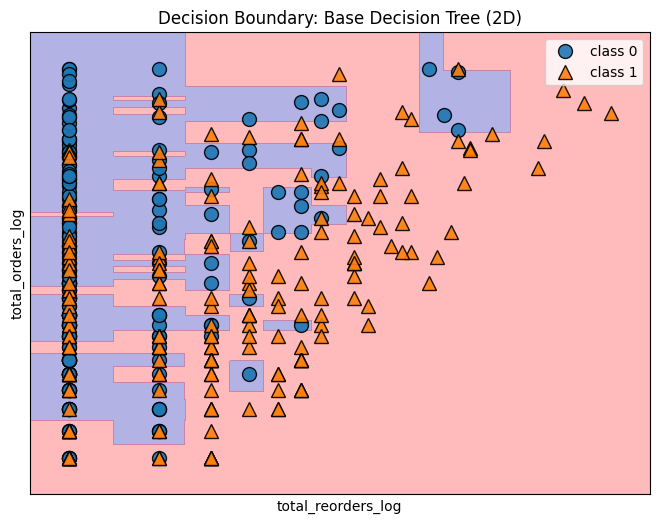

In [ ]:
feat1="total_reorders_log"
feat2="total_orders_log"

dfp=df_train[[feat1, feat2, "reordered"]]
pos=dfp[dfp["reordered"] == 1].sample(n=200, random_state=42)
neg=dfp[dfp["reordered"] == 0].sample(n=200, random_state=42)
dfp=pd.concat([pos, neg]).sample(frac=1,random_state=42)

X=dfp[[feat1, feat2]].to_numpy()
y=dfp["reordered"].to_numpy()

pip_tree_2d = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier(random_state=42))
])

pip_tree_2d.fit(X, y)

plt.figure(figsize=(8, 6))
mglearn.plots.plot_2d_separator(pip_tree_2d, X, fill=True, alpha=0.3,eps=0.3)
mglearn.discrete_scatter(X[:, 0], X[:, 1],y,alpha=0.9,s=10)

plt.xlabel("total_reorders_log")
plt.ylabel("total_orders_log")
plt.title("Decision Boundary: Base Decision Tree (2D)")
plt.legend(["class 0", "class 1"], loc="best")
plt.show()

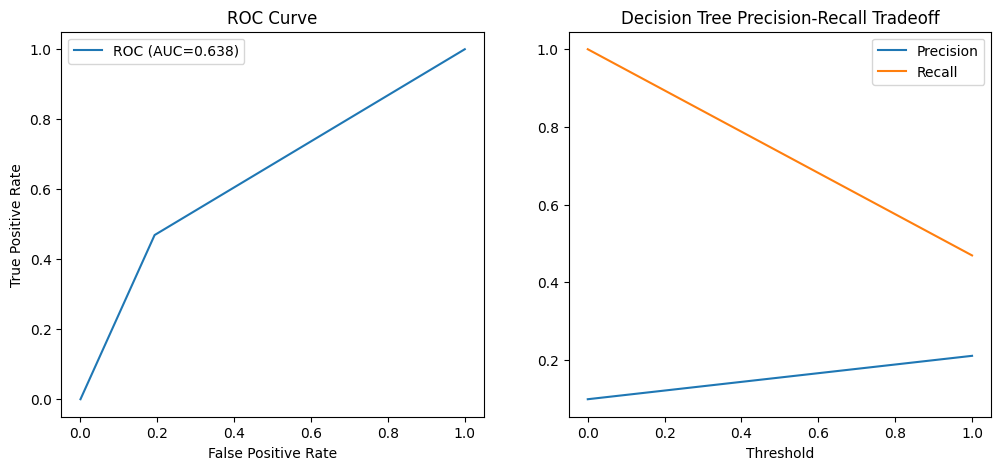

In [287]:
precisions,recalls,thresholds=precision_recall_curve(y_val_us,proba)

fpr,tpr,thr=roc_curve(y_val_us,proba)
auc=roc_auc_score(y_val_us, proba)
fig,axes=plt.subplots(1,2,figsize=(12,5))

axes[0].plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend()


axes[1].plot(thresholds,precisions[:-1],label='Precision')
axes[1].plot(thresholds,recalls[:-1], label='Recall')
axes[1].set_title("Decision Tree Precision-Recall Tradeoff")
axes[1].set_xlabel('Threshold')
axes[1].legend()


# Tunned Tree

We also Used 500k rows for RandomizedSearchcv

In [93]:
tree_tune_pipe=Pipeline([
    ("preprocess",ct),
    ("tree",DecisionTreeClassifier(random_state=42))])

param_dist={
"tree__max_depth":[6, 8, 10, 12, 14, 16, 20, 25],
"tree__min_samples_split":[2, 10, 50, 100, 200, 500, 1000],
"tree__min_samples_leaf":[10, 25, 50, 100, 200, 500],
"tree__max_features":[None, "sqrt", "log2", 0.3, 0.5, 0.7],
"tree__criterion":["gini", "entropy", "log_loss"],
"tree__class_weight":[None,'balanced'],
}                                                                                                               
                                                                                                                                                                                                                                 
tcvs=TimeSeriesSplit(n_splits=3)
randomsearch=RandomizedSearchCV(tree_tune_pipe,param_distributions=param_dist,scoring='average_precision',n_jobs=-1,cv=tcvs,n_iter=80,random_state=42)
randomsearch.fit(X_train_us.drop(id_col,axis=1),y_train_us)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'tree__class_weight': [None, 'balanced'], 'tree__criterion': ['gini', 'entropy', ...], 'tree__max_depth': [6, 8, ...], 'tree__max_features': [None, 'sqrt', ...], ...}"
,n_iter,80
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [203]:
randomsearch.best_params_

{'tree__min_samples_split': 2,
 'tree__min_samples_leaf': 200,
 'tree__max_features': None,
 'tree__max_depth': 20,
 'tree__criterion': 'entropy',
 'tree__class_weight': None}

Training the tunned tree and validate it on the full dataset

In [204]:
best_tree=randomsearch.best_estimator_                                                                
best_tree.fit(X_train.drop(id_col,axis=1),y_train)                                                                                                                                                                                   

,steps,"[('preprocess', ...), ('tree', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('one hot', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Heatmap shows that there are more than one min_samples_leaf and max depth values that reached highest AP.

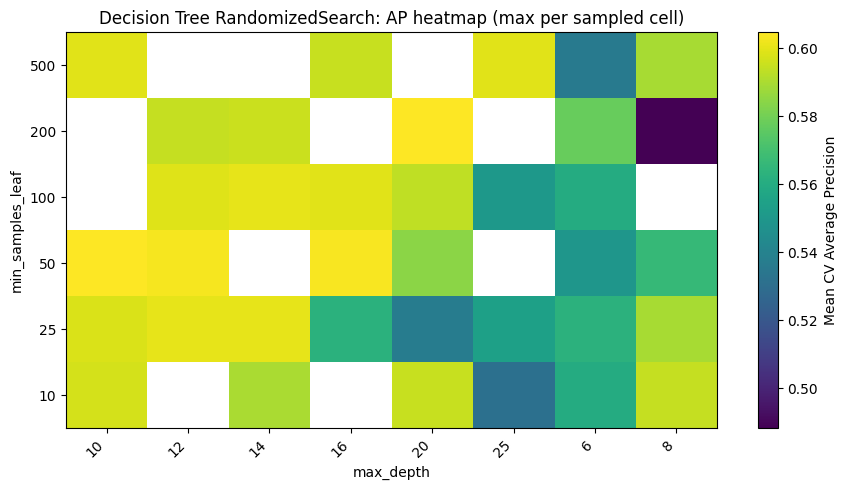

In [205]:
res = pd.DataFrame(randomsearch.cv_results_)
p1="param_tree__max_depth"
p2="param_tree__min_samples_leaf"

res[p1]=res[p1].astype(str)  
heat=res.pivot_table(index=p2,columns=p1,values="mean_test_score",aggfunc="max").sort_index()

plt.figure(figsize=(9,5))
plt.imshow(heat.values, aspect="auto", origin="lower")
plt.xticks(range(len(heat.columns)),heat.columns,rotation=45, ha="right")
plt.yticks(range(len(heat.index)), heat.index)
plt.xlabel("max_depth")
plt.ylabel("min_samples_leaf")
plt.title("Decision Tree RandomizedSearch: AP heatmap (max per sampled cell)")
plt.colorbar(label="Mean CV Average Precision")
plt.tight_layout()
plt.show()


 Threshold that **f1** is highest at .

In [211]:
proba_tree=best_tree.predict_proba(X_val.drop(id_col,axis=1))[:,1]
y_pred=best_tree.predict(X_val.drop(id_col,axis=1))
print(classification_report(y_val,proba_tree>=0.2))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92    762527
           1       0.35      0.52      0.42     83044

    accuracy                           0.86    845571
   macro avg       0.65      0.71      0.67    845571
weighted avg       0.89      0.86      0.87    845571



The model is ~ 4X Better than a random guess.

In [ ]:
print("AP: ",average_precision_score(y_val,proba_tree))
print('pos rate: ',y_val.mean())
print("ROC-AUC:",roc_auc_score(y_val,proba_tree))

AP:  0.3905805042099562
pos rate:  0.09821055830911893
ROC-AUC: 0.8106207365309325


The ROC curve shows the tradeoff between True Positive Rate (recall) and False Positive Rate across all thresholds.  
The tuned decision tree achieves **ROC-AUC = 0.811**, indicating good ranking ability (well above random at 0.5).

As the decision threshold increases, the model predicts fewer positives. This increases **precision** but decreases **recall**.  
A lower threshold favors recall (more reordered items captured), while a higher threshold favors precision (fewer false positives).The final threshold was selected based on the f1 score as it the balance between recall and precision.

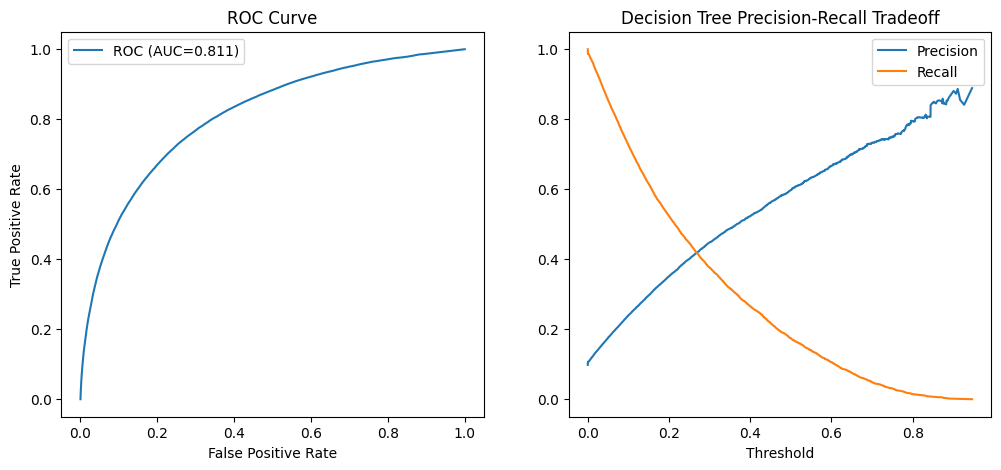

In [281]:
precisions,recalls,thresholds=precision_recall_curve(y_val,proba_tree)

fpr,tpr,thr=roc_curve(y_val,proba_tree)
auc=roc_auc_score(y_val, proba_tree)
fig,axes=plt.subplots(1,2,figsize=(12,5))

axes[0].plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend()


axes[1].plot(thresholds,precisions[:-1],label='Precision')
axes[1].plot(thresholds,recalls[:-1], label='Recall')
axes[1].set_title("Decision Tree Precision-Recall Tradeoff")
axes[1].set_xlabel('Threshold')
axes[1].legend()


Text(0.5, 1.0, 'Confusion Matrix (normalized)')

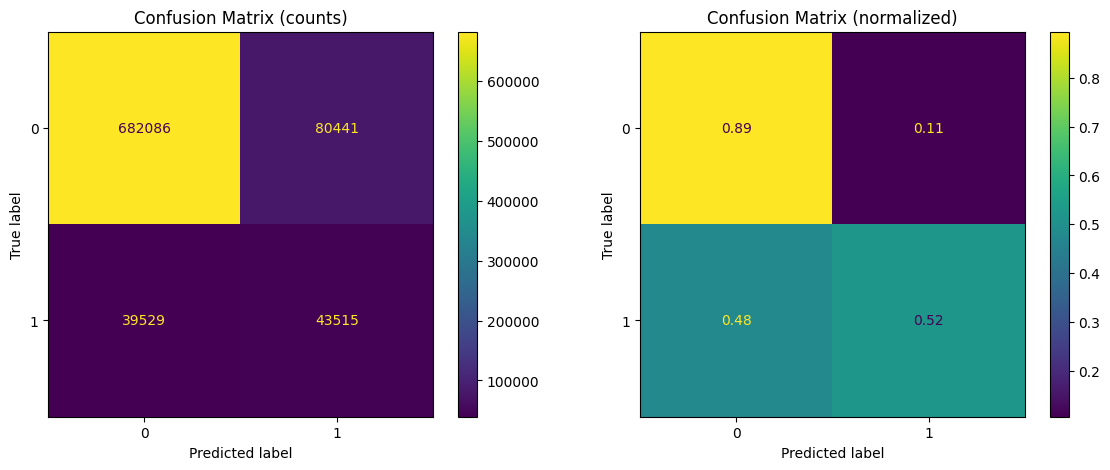

In [282]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
ConfusionMatrixDisplay.from_predictions(y_val,proba_tree>=0.2,normalize=None,ax=axes[0],values_format='d')
axes[0].set_title("Confusion Matrix (counts)")

ConfusionMatrixDisplay.from_predictions(y_val,proba_tree>=0.2,normalize="true",ax=axes[1],values_format='.2f')
axes[1].set_title("Confusion Matrix (normalized)")

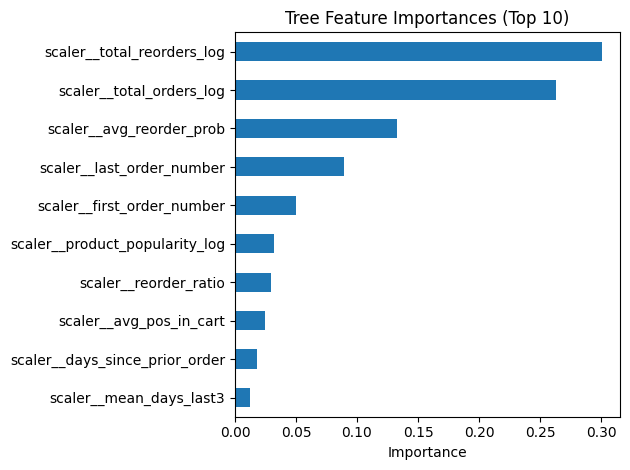

In [217]:
feat_names = best_tree.named_steps["preprocess"].get_feature_names_out()
tree_model = best_tree.named_steps["tree"]
importances = tree_model.feature_importances_

fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)

topn = 10
plt.figure()
fi.head(topn).sort_values().plot(kind="barh")
plt.title(f"Tree Feature Importances (Top {10})")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

The tuned decision tree produces a much simpler 2D decision boundary than the base tree. This is mainly due to strong regularization through `min_samples_leaf=200` and the other constraints.

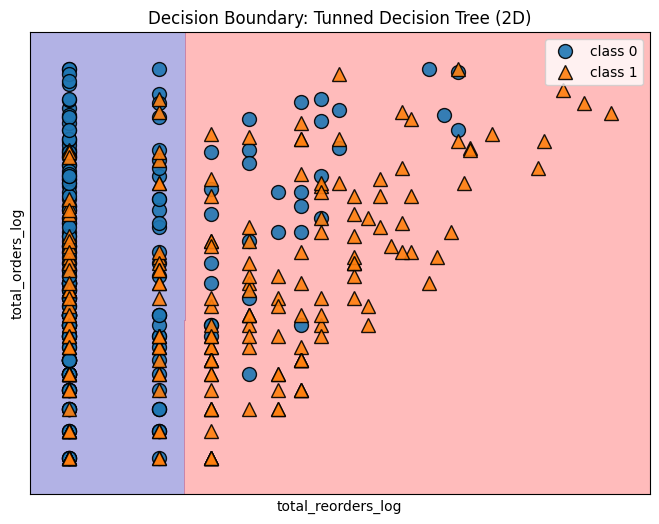

In [ ]:
feat1="total_reorders_log"
feat2="total_orders_log"

dfp=df_train[[feat1, feat2, "reordered"]]
pos=dfp[dfp["reordered"] == 1].sample(n=200, random_state=42)
neg=dfp[dfp["reordered"] == 0].sample(n=200, random_state=42)
dfp=pd.concat([pos, neg]).sample(frac=1, random_state=42)

X=dfp[[feat1, feat2]].to_numpy()
y=dfp["reordered"].to_numpy()

pip_tree_2d=Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier(max_depth=20,min_samples_leaf=200,min_samples_split=2,criterion='entropy',random_state=42))
])

pip_tree_2d.fit(X, y)

plt.figure(figsize=(8, 6))
mglearn.plots.plot_2d_separator(pip_tree_2d, X, fill=True, alpha=0.3,eps=0.3)
mglearn.discrete_scatter(X[:, 0], X[:, 1],y,alpha=0.9,s=10)

plt.xlabel("total_reorders_log")
plt.ylabel("total_orders_log")
plt.title("Decision Boundary: Tunned Decision Tree (2D)")
plt.legend(["class 0", "class 1"], loc="best")
plt.show()

The calibration curve indicates that the decision tree’s predicted probabilities are generally reliable.

At higher probability ranges (0.8 ~ 0.9) the curve is slightly under the diagonal, which means the model is mild **overconfident**.

Brier: 0.07303030863298597


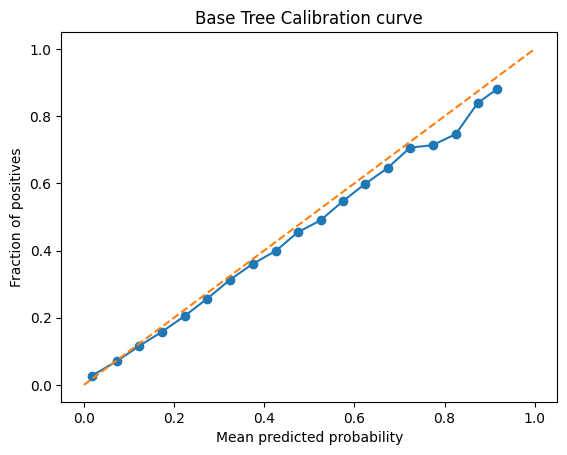

In [218]:
prob_true,prob_pred=calibration_curve(y_val,proba_tree,n_bins=20)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Base Tree Calibration curve")

brier = brier_score_loss(y_val,proba_tree)
print("Brier:", brier)

## Support Vector Machine.

## LinearSVC

In [22]:
pos = df_train[df_train['reordered'] == 1]
neg = df_train[df_train['reordered'] == 0]

ratio=3
max_train=50000

pos_keep = min(len(pos), max_train // (1 + ratio))
pos_s = pos.sample(n=pos_keep, random_state=42)

neg_keep = min(len(neg), ratio * pos_keep)
neg_s = neg.sample(n=neg_keep, random_state=42)

df_train_us = pd.concat([pos_s, neg_s]).sort_values('order_id').reset_index(drop=True)

X_train_us = df_train_us.drop(columns=['reordered'])
y_train_us = df_train_us['reordered']

val_n=10000
idx = X_val.sample(n=min(val_n, len(X_val)), random_state=42).index
X_val_us = X_val.loc[idx].copy()
y_val_us = y_val.loc[idx].copy()

order = X_val_us['order_id'].sort_values().index
X_val_us = X_val_us.loc[order]
y_val_us = y_val_us.loc[order]                                                                                                                                                                                                                                 

## Base linearSVC

linear SVM is relatively scalable because it learns a single linear boundary. Training cost increases mainly with the **number of samples and features** (roughly proportional to n × d). It can still become slow on millions of rows or very high-dimensional one-hot features, especially with cross-validation, but it remains far more feasible than kernel SVM for large datasets.

In [25]:
lin_svm=Pipeline([
    ("preprocess", ct),
    ("svm", LinearSVC(random_state=42))
])

lin_svm.fit(X_train.drop(id_col,axis=1),y_train)
y_pred=lin_svm.predict(X_val.drop(id_col,axis=1))

In [69]:
scores=lin_svm.decision_function(X_val)
print("ROC-AUC:",roc_auc_score(y_val, scores))
print("AP:",average_precision_score(y_val, scores))
print("train Score: ",lin_svm.score(X_train,y_train))
print("Val Score: ",lin_svm.score(X_val,y_val))

ROC-AUC: 0.8047112219578585
AP: 0.3692922594543187
train Score:  0.9026906223415899
Val Score:  0.9022246505615732


Threshold that f1 is highest at (-0.6).

In [81]:
print(classification_report(y_val,scores>=-0.6))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93    762527
           1       0.36      0.46      0.40     83044

    accuracy                           0.87    845571
   macro avg       0.65      0.68      0.66    845571
weighted avg       0.88      0.87      0.87    845571



For the linear SVM, the “threshold” on the x-axis is applied to the **decision_function** output (the SVM margin), not a probability.  
These scores can be **negative or positive**:

- **Score > threshold** → the model predicts class 1  
- **Score < threshold** → the model predicts class 0  
- **Threshold = 0** is the default SVM decision boundary

Moving the threshold to the **left (more negative)** classifies more samples as positive, which increases **recall** but decreases **precision**.  
Moving the threshold to the **right (more positive)** makes the model more conservative, which increases **precision** but decreases **recall**.  
This produces the expected precision–recall tradeoff across different operating points.


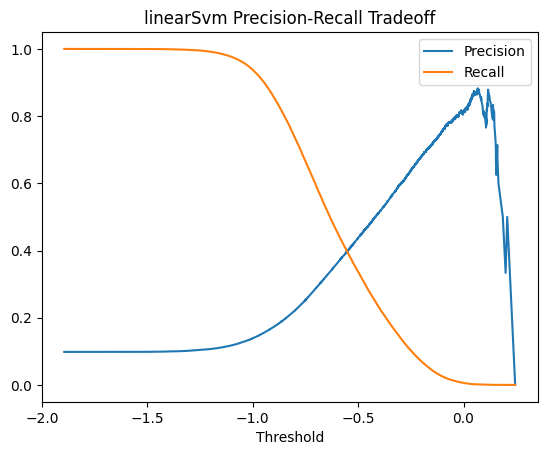

In [82]:
precisions,recalls,thresholds=precision_recall_curve(y_val,scores)

plt.plot(thresholds,precisions[:-1],label='Precision')
plt.plot(thresholds,recalls[:-1], label='Recall')
plt.title("linearSvm Precision-Recall Tradeoff")
plt.xlabel('Threshold')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion Matrix (normalized)')

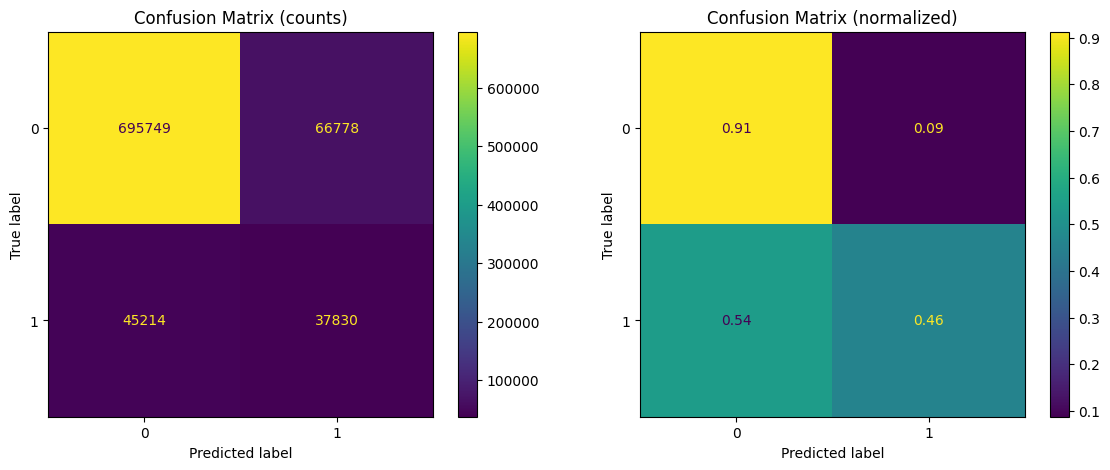

In [83]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
ConfusionMatrixDisplay.from_predictions(y_val,scores>=-0.6,normalize=None,ax=axes[0],values_format='d')
axes[0].set_title("Confusion Matrix (counts)")

ConfusionMatrixDisplay.from_predictions(y_val,scores>=-0.6,normalize="true",ax=axes[1],values_format='.2f')
axes[1].set_title("Confusion Matrix (normalized)")

LinearSVC produces a straight-line decision boundary because its decision score is a linear combination of the features.

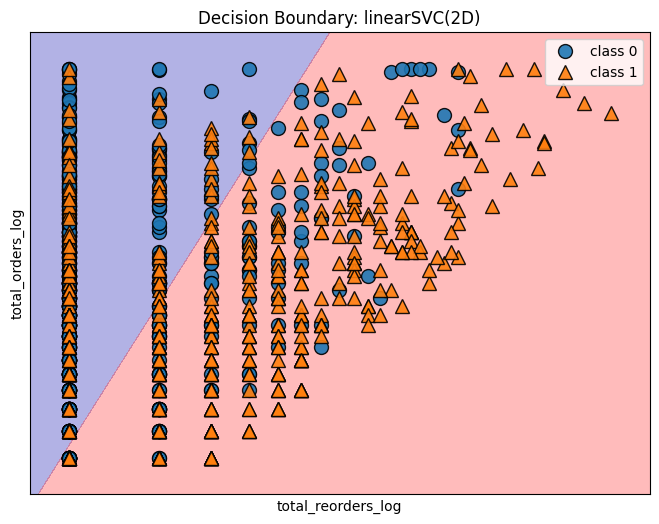

In [68]:
feat1="total_reorders_log"
feat2="total_orders_log"

dfp=df_train[[feat1, feat2, "reordered"]]
pos=dfp[dfp["reordered"] == 1].sample(n=500, random_state=42)
neg=dfp[dfp["reordered"] == 0].sample(n=500, random_state=42)
dfp=pd.concat([pos, neg]).sample(frac=1, random_state=42)

X=dfp[[feat1, feat2]].to_numpy()
y=dfp["reordered"].to_numpy()

LinearSVC_2d=Pipeline([
    ("scaler", StandardScaler()),
    ("SVC", LinearSVC(random_state=42))
])

LinearSVC_2d.fit(X, y)
plt.figure(figsize=(8, 6))
mglearn.plots.plot_2d_separator(LinearSVC_2d,X,fill=True,alpha=0.3,eps=0.3)
mglearn.discrete_scatter(X[:, 0], X[:, 1],y,alpha=0.9,s=10)

plt.xlabel("total_reorders_log")
plt.ylabel("total_orders_log")
plt.title("Decision Boundary: linearSVC(2D)")
plt.legend(["class 0", "class 1"], loc="best")
plt.show()

LinearSVC outputs decision scores, not probabilities. We calibrated it to convert scores into meaningful probabilities, so we can interpret outputs and choose thresholds reliably

Text(0.5, 1.0, 'linearSVC calibration curve')

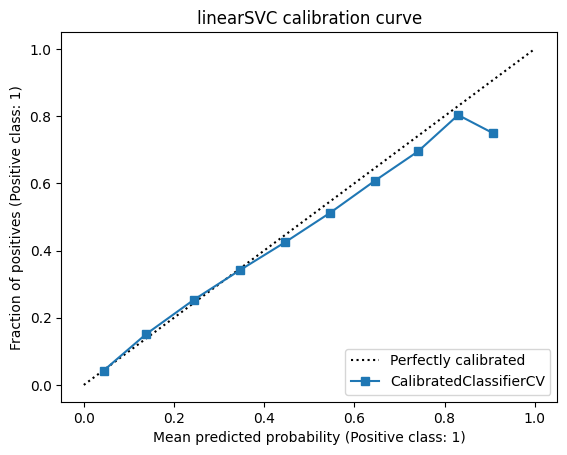

In [ ]:
tscv=TimeSeriesSplit(n_splits=3)
cal = CalibratedClassifierCV(lin_svm,method="sigmoid", cv=tscv)

cal.fit(X_train, y_train)
CalibrationDisplay.from_estimator(cal,X_val,y_val,n_bins=10)
plt.title('linearSVC calibration curve')

In [88]:
proba=cal.predict_proba(X_val)[:, 1]
brier=brier_score_loss(y_val, proba)
print("Brier score:", brier)

Brier score: 0.07467332250700075


## Kernal



Kernel SVMs (e.g., RBF/poly) become computationally expensive as the number of training samples increases because training relies on pairwise kernel evaluations between samples. This creates an implicit **n×n** interaction structure, which requires large memory and many computations. As a result, training time and memory usage grow very quickly (often close to quadratic in n), so running a kernel SVM on hundreds of thousands or millions of rows is typically infeasible.

Therefore, kernel SVMs are evaluated only on a small subset of the data (50k row for train and 10k row for validation) for demonstration.


In [62]:
rbf_svm = Pipeline([
    ("preprocess", ct),
    ("scale", StandardScaler(with_mean=False)),
    ("svm", SVC(random_state=42))
])
rbf_svm.fit(X_train_us.drop(id_col,axis=1), y_train_us)

,steps,"[('preprocess', ...), ('scale', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [35]:
scores=rbf_svm.decision_function(X_val_us.drop(id_col,axis=1))
y_svc=rbf_svm.predict(X_val_us.drop(id_col,axis=1))
print("ROC-AUC:",roc_auc_score(y_val_us, scores))
print("AP:",average_precision_score(y_val_us, scores))
print("train Score: ",rbf_svm.score(X_train_us,y_train_us))
print("Val Score: ",rbf_svm.score(X_val_us,y_val_us))

ROC-AUC: 0.7899187205824706
AP: 0.37987813772996415
train Score:  0.81352
Val Score:  0.888


F1 was 0.41 at thresholds -0.5 to -0.1 (the cross in the precsion-recall tradeoff plot).

In [56]:
print(classification_report(y_val_us,scores>=-0.5))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      8985
           1       0.34      0.52      0.41      1015

    accuracy                           0.85     10000
   macro avg       0.64      0.70      0.66     10000
weighted avg       0.88      0.85      0.86     10000



Same explaintion for linearSVM precsion-recall tradeoff is applied here. 

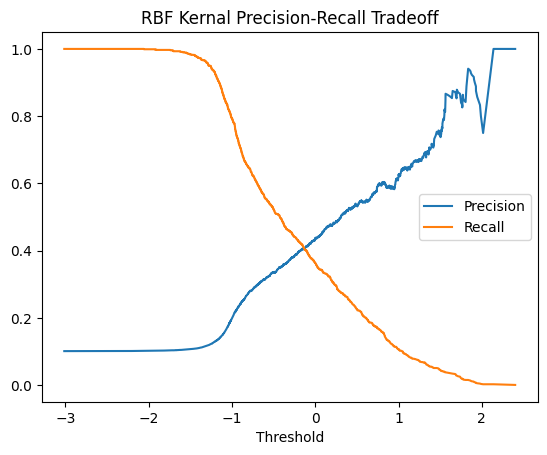

In [29]:
precisions,recalls,thresholds=precision_recall_curve(y_val_us,scores)

plt.plot(thresholds,precisions[:-1],label='Precision')
plt.plot(thresholds,recalls[:-1], label='Recall')
plt.title("RBF Kernal Precision-Recall Tradeoff")
plt.xlabel('Threshold')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion Matrix (normalized)')

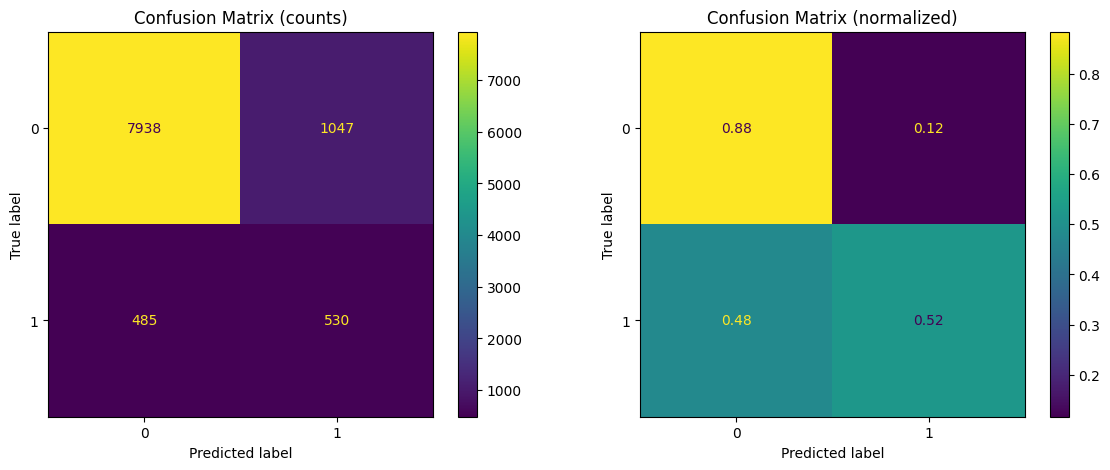

In [57]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
ConfusionMatrixDisplay.from_predictions(y_val_us,scores>=-0.5,normalize=None,ax=axes[0],values_format='d')
axes[0].set_title("Confusion Matrix (counts)")

ConfusionMatrixDisplay.from_predictions(y_val_us,scores>=-0.5,normalize="true",ax=axes[1],values_format='.2f')
axes[1].set_title("Confusion Matrix (normalized)")

kernal produces non linear line (wiggly , curve) because it uses a kernel function to measure similarity to support vectors.

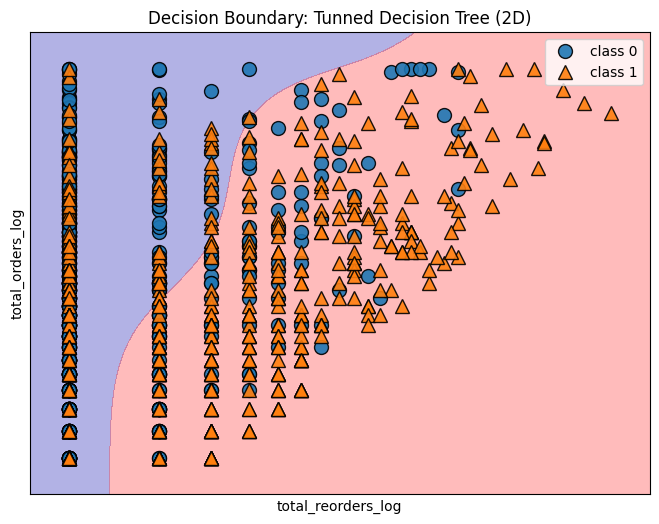

In [ ]:
feat1="total_reorders_log"
feat2="total_orders_log"

dfp=df_train[[feat1, feat2, "reordered"]]
pos=dfp[dfp["reordered"] == 1].sample(n=500, random_state=42)
neg=dfp[dfp["reordered"] == 0].sample(n=500, random_state=42)
dfp=pd.concat([pos, neg]).sample(frac=1, random_state=42)

X=dfp[[feat1, feat2]].to_numpy()
y=dfp["reordered"].to_numpy()

svm_2d=Pipeline([
    ("scaler", StandardScaler()),
    ("SVC", SVC(random_state=42))
])

svm_2d.fit(X, y)
plt.figure(figsize=(8, 6))
mglearn.plots.plot_2d_separator(svm_2d, X, fill=True, alpha=0.3,eps=0.3)
mglearn.discrete_scatter(X[:, 0], X[:, 1],y,alpha=0.9,s=10)

plt.xlabel("total_reorders_log")
plt.ylabel("total_orders_log")
plt.title("Decision Boundary: Tunned Decision Tree (2D)")
plt.legend(["class 0", "class 1"], loc="best")
plt.show()